# XGBoost Train
- 코드 B00_03_train 참고
- 피처엔지니어링 v01

In [1]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from datetime import datetime

# 하이퍼파라미터 최적화
import optuna
from optuna.samplers import TPESampler


In [2]:
# =============================================================================
# 셀 2: 경로 설정 및 디렉토리 생성
# =============================================================================
# 경로 설정
data_dir = '/workspace/AI모델/projects/coin/data/1h/xgboost_B'
output_dir = '/workspace/AI모델/projects/coin/models/1h'

# 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)

# 설정값
N_FOLDS = 5     
N_TRIALS = 15   # n 번 시도
RANDOM_STATE = 42

# GPU 최적화 설정
USE_GPU = True
GPU_DEVICE = 'cuda:0'
GPU_BATCH_SIZE = 10000
PARALLEL_JOBS = 1      # GPU 사용시에는 1 또는 2가 최적

# 메모리 모니터링 활성화
MEMORY_MONITORING = True

print(f"데이터 디렉토리: {data_dir}")
print(f"출력 디렉토리: {output_dir}")
print(f"K-Fold: {N_FOLDS}폴드, Optuna 시도: {N_TRIALS}회 (메모리 안전 모드)")
print(f"GPU 사용: {USE_GPU}")

# 시스템 메모리 확인
import psutil
total_ram = psutil.virtual_memory().total / (1024**3)
available_ram = psutil.virtual_memory().available / (1024**3)
print(f"시스템 RAM: {total_ram:.1f}GB (사용가능: {available_ram:.1f}GB)")

데이터 디렉토리: /workspace/AI모델/projects/coin/data/1h/xgboost_B
출력 디렉토리: /workspace/AI모델/projects/coin/models/1h
K-Fold: 5폴드, Optuna 시도: 15회 (메모리 안전 모드)
GPU 사용: True
시스템 RAM: 47.0GB (사용가능: 37.3GB)


# 주의! Data load
- 기존에 만든 병합된 학습용 데이터 /workspace/AI모델/projects/coin/data/xgboost_B
- 여기서의 라벨은 'Optimized_Label'임 이걸 -> Future_Label로 변환함 따라서 Future_Label이 진짜라벨

In [3]:
# =============================================================================
# 셀 3: 데이터 로드 및 전처리
# =============================================================================

def load_and_prepare_data(data_dir):
    """
    training_features.txt를 읽어서 기본 피처를 로드하고,
    추가 제외 항목을 적용하여 데이터 전처리
    """
    print("데이터 로드 및 전처리 시작...")
    
    # 1. training_features.txt 파일 읽기
    feature_file = os.path.join(data_dir, 'training_features.txt')
    
    if os.path.exists(feature_file):
        with open(feature_file, 'r') as f:
            base_features = [line.strip() for line in f.readlines() if line.strip()]
        print(f"training_features.txt에서 {len(base_features)}개 기본 피처 로드")
    else:
        print(f"⚠️ training_features.txt 파일이 없습니다: {feature_file}")
        base_features = None
    
    # 2. 데이터 로드
    train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
    val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
    
    print(f"\n데이터 로드 완료:")
    print(f"  훈련: {train_df.shape}")
    print(f"  검증: {val_df.shape}")
    print(f"  테스트: {test_df.shape}")
        
    # 3. 추가로 제외할 피쳐들 정의 (상관관계/VIF 분석 기반)
    additional_exclude = [
        # === 완전 중복 제거 (상관계수 1.0) ===
        # Williams_R 그룹 (Williams_R_14 = Williams_R = Stoch_K_14)
        'Williams_R', 'Williams_R_14', 'Stoch_K_14',
        
        # CCI 그룹 (CCI_20 = CCI)
        'CCI',
        
        # MFI 그룹 (MFI_14 = MFI)
        'MFI',
        
        # RSI normalized 그룹들 (원본과 1.0 상관)
        'RSI_4_normalized', 'RSI_5_normalized', 'RSI_6_normalized', 
        'RSI_7_normalized', 'RSI_12_normalized', 'RSI_14_normalized', 
        'RSI_20_normalized', 'RSI_21_normalized',
        
        # MACD 관련 완전 중복
        'MACD_10_20_signal_distance', 'MACD_15_26_signal_distance', 'MACD_5_27_signal_distance',
        
        # MA Cross 시그널들 (서로 완전 중복)
        'MA_Cross_3_25_Signal_distance', 'MA_Trend_Signal_ratio', 
        'MA_Trend_Signal_distance', 'EMA_Cross_5_20_Signal_ratio', 'EMA_Cross_6_24_Signal_ratio',
        
        # 볼린저밴드 완전 중복들
        'BB_Width_20', 'Volatility_20',
        
        # Pivot 관련 완전 중복
        'Support1', 'Resistance1',
        
        # Highest/Lowest 그룹들 (서로 0.99+ 상관)
        'Lowest_3', 'Highest_7', 'Lowest_7', 'Highest_8', 'Lowest_8',
        'Highest_10', 'Lowest_10', 'Highest_11', 'Lowest_11',
        'Highest_16', 'Lowest_16', 'Highest_17', 'Lowest_17',
        'Highest_28', 'Lowest_28',
        
        # === 높은 상관관계 (0.95+ 제거) ===
        'MACD_15_26', 'BB_Upper_20', 'BB_Lower_20', 'Stoch_D_14',
        'MA_7_ratio', 'MA_8_ratio', 'MA_25_ratio', 'MA_29_ratio', 
        'MA_60_ratio', 'MA_120_ratio', 'EMA_24_ratio', 'Close_return',
        
        # === VIF 무한대인 피쳐들 ===
        'RSI_Reverse_Signal', 'RSI_Extreme_Signal', 'RSI_20_75_Signal',
        'RSI_22_78_Signal', 'RSI_30_65_Signal', 'RSI_12_50_Signal',
        'MACD_Signal_Cross', 'RSI_Divergence', 'MACD_Cross',
        'MA_16_distance', 'MA_16_ratio',
        'MA_25_distance', 'MA_29_distance', 'MA_13_distance', 
        'MA_60_distance', 'MA_8_distance', 'MA_4_ratio', 
        'MA_5_ratio', 'MA_4_distance', 'MA_100_distance',
        
        # === 기존 제거 항목들 ===
        'Volume_MA_20', 'MA_3', 'MA_5', 'MA_7', 'MA_10', 'MA_50',
        'EMA_26', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_relative_position',
        'MACD_Signal', 'MACD_Histogram', 'MACD_signal_distance',
        'RSI_normalized', '%D', 'Close_log_return', 'Open_log_return', 
        'Open_return', 'High_log_return', 'High_return', 'Low_log_return', 
        'Low_return', 'Return_2d', 'Return_3d', 'Return_7d', 'Return_10d', 
        'Return_14d', 'Return_21d', 'Return_42d', 'Return_63d',
        'MA_5_distance', 'MA_10_distance', 'MA_20_distance', 
        'MA_50_distance', 'MA_200_distance',
        'Future_1d', 'Future_3d', 'Future_7d', 'Future_14d', 
        'Future_30d', 'Future_90d', 'Future_180d', 'Future_365d',
        'True_Range', 'Volatility_20d', 'Stoch_overbought', 'Stoch_oversold',
        'SMI_Signal', 'quarter', 'dow_cos',
        'BB_upper_distance', 'BB_lower_distance', 'EMA_12_ratio', 'EMA_26_ratio',
        
        # === 새로 추가: 높은 다중공선성 피처들 (VIF > 100) ===
        'Sell_Signal_Count', 'Net_Signal_Score', 'Buy_Signal_Count',
        'MA_6_ratio', 'EMA_6_ratio', 'MA_20_ratio', 'EMA_20_ratio',
        'MA_50_ratio', 'MA_7_distance', 'MA_6_distance',
        'MA_10_ratio', 'EMA_5_ratio', 'EMA_50_ratio', 'EMA_10_ratio',
        
        # === 새로 추가: Permutation 악영향 피처들 (제거시 성능 향상) ===
        'Return_1d', 'MA_2_ratio', 'MA_2_distance', 'Price_Momentum_5',
        'Stoch_K_1', 'MA_3_ratio', 'Pivot_Strategy_Signal', 'MA_120_distance',
        'realized_volatility_20', 'RSI_4', 'MA_3_distance', 'RSI_21',
        'EMA_4_ratio', 'Stoch_D_6', 'Return_90d',
        'Williams_R_10', 'EMA_7_ratio', 'MA_8_distance', 'CCI_4', 
        'Stoch_K_6', 'RSI_20', 'Williams_R_1', 'RSI_5', 
        'Stoch_K_4', 'Stoch_D_3', 'Price_vs_MA7', 'ATR_14',
        'EMA_3_ratio', 'MA_4_ratio', 'MA_4_distance',
        
        # === 새로 추가: 중요도 0인 무용 피처들 === 
        'RSI_Reverse_Signal_overbought', 'RSI_Divergence_oversold', 'ADX_21',
        'RSI_Reverse_Signal_oversold', 'RSI_Divergence_overbought',
        'CCI_3_Signal', 'RSI_20_75_Signal_overbought', 'RSI_20_75_Signal_oversold',
        'RSI_30_65_Signal_oversold', 'RSI_12_50_Signal_oversold', 'STD_1',
        'RSI_22_78_Signal_overbought', 'RSI_22_78_Signal_oversold',
        'CCI_3_Signal_oversold', 'CCI_3_Signal_overbought',
        'CCI_Oversold_Signal_oversold', 'CCI_Oversold_Signal_overbought',
        'RSI_12_50_Signal_overbought', 'RSI_Extreme_Signal_overbought', 'RSI_Extreme_Signal_oversold',
        'RSI_30_65_Signal_overbought', 'RSI_Reversal_Signal_oversold',
    ]
    
    # 4. 최종 피쳐 결정
    if base_features is not None:
        # training_features.txt에서 추가 제외 항목을 빼기
        feature_columns = [f for f in base_features if f not in additional_exclude]
        print(f"\ntraining_features.txt 기반 피처: {len(base_features)}개")
        print(f"추가 제외 항목: {len(additional_exclude)}개")
    else:
        # training_features.txt가 없으면 전체 컬럼에서 제외
        exclude_all = [
            'Future_Label', 'Label', 'Label_Name', 'Optimized_Label', 'Optimized_Label_Name',
            'Symbol', 'Date', 'Symbol_encoded', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Composite_Signal_Avg', 'Buy_Signal_Count', 'Sell_Signal_Count',
            'Net_Signal_Score', 'Final_Composite_Signal', 'Price_Momentum_5',
            'Price_Momentum_10', 'Price_Momentum_20', 'Price_Position',
        ] + additional_exclude
        
        feature_columns = [col for col in train_df.columns if col not in exclude_all]
    
    # 5. 실제 존재하는 피쳐만 필터링
    feature_columns = [col for col in feature_columns if col in train_df.columns]
    
    # Future_Label 제거 (타겟이므로)
    if 'Future_Label' in feature_columns:
        feature_columns.remove('Future_Label')
    
    print(f"\n최종 피쳐 수: {len(feature_columns)}")
    
    # 6. Future_Label 확인
    if 'Future_Label' not in train_df.columns:
        raise ValueError("Future_Label 컬럼이 없습니다!")
    
    # 7. 훈련+검증 데이터 합치기
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)
    
    # 8. 피쳐와 타겟 분리
    X_train_val = train_val_df[feature_columns].fillna(0)
    y_train_val = train_val_df['Future_Label']
    
    X_test = test_df[feature_columns].fillna(0)
    y_test = test_df['Future_Label']
    
    # 9. 무한값 처리
    X_train_val = X_train_val.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)
    
    print(f"\n데이터 전처리 완료:")
    print(f"  X_train_val: {X_train_val.shape}")
    print(f"  X_test: {X_test.shape}")
    
    # 10. 클래스 분포 확인
    print(f"\n클래스 분포:")
    label_names = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
    
    for name, y in [("훈련+검증", y_train_val), ("테스트", y_test)]:
        counts = y.value_counts().sort_index()
        pcts = (counts / len(y) * 100).round(1)
        
        print(f"  {name}:")
        for label, count in counts.items():
            pct = pcts[label]
            label_name = label_names.get(int(label), f'Label_{int(label)}')
            print(f"    {int(label)} ({label_name}): {count:,}개 ({pct}%)")
    
    # 11. 클래스 균형도
    class_ratio = y_train_val.value_counts().min() / y_train_val.value_counts().max()
    print(f"\n클래스 균형도: {class_ratio:.3f} (1.0에 가까울수록 균형)")
    
    # 12. 데이터 검증
    print(f"\n데이터 검증:")
    print(f"  결측치 - X_train_val: {X_train_val.isnull().sum().sum()}")
    print(f"  결측치 - X_test: {X_test.isnull().sum().sum()}")
    print(f"  무한값 - X_train_val: {np.isinf(X_train_val.values).sum()}")
    print(f"  무한값 - X_test: {np.isinf(X_test.values).sum()}")
    
    return X_train_val, X_test, y_train_val, y_test, feature_columns


X_train_val, X_test, y_train_val, y_test, feature_columns = load_and_prepare_data(data_dir)

print(f"\n데이터 준비 완료!")
print(f"사용할 피쳐 수: {len(feature_columns)}")
print(f"샘플 피쳐들:")
for i, feat in enumerate(feature_columns[:15]):
    print(f"  {i+1:2d}. {feat}")
if len(feature_columns) > 15:
    print(f"  ... 외 {len(feature_columns)-15}개")

데이터 로드 및 전처리 시작...
training_features.txt에서 374개 기본 피처 로드

데이터 로드 완료:
  훈련: (242173, 389)
  검증: (51894, 389)
  테스트: (51895, 389)

training_features.txt 기반 피처: 374개
추가 제외 항목: 193개

최종 피쳐 수: 198

데이터 전처리 완료:
  X_train_val: (294067, 198)
  X_test: (51895, 198)

클래스 분포:
  훈련+검증:
    0 (Sell): 25,989개 (8.8%)
    1 (Hold): 242,092개 (82.3%)
    2 (Buy): 25,986개 (8.8%)
  테스트:
    0 (Sell): 4,508개 (8.7%)
    1 (Hold): 42,904개 (82.7%)
    2 (Buy): 4,483개 (8.6%)

클래스 균형도: 0.107 (1.0에 가까울수록 균형)

데이터 검증:
  결측치 - X_train_val: 0
  결측치 - X_test: 0
  무한값 - X_train_val: 0
  무한값 - X_test: 0

데이터 준비 완료!
사용할 피쳐 수: 198
샘플 피쳐들:
   1. MA_2
   2. MA_4
   3. MA_6
   4. MA_8
   5. MA_13
   6. MA_16
   7. MA_20
   8. MA_25
   9. MA_29
  10. MA_60
  11. MA_100
  12. MA_120
  13. MA_200
  14. EMA_3
  15. EMA_4
  ... 외 183개


# Data Check

In [4]:
import pandas as pd
pd.set_option("display.max_columns", None)   # 컬럼 생략 없이 전부 출력

import pandas as pd
pd.set_option("display.max_columns", None)

print("\n=== 상위 3개 행 ===")
display(X_train_val.head(3))

print("=== DataFrame 정보 ===")
print(X_train_val.info(verbose=True)) # info() 대신 .. 너무길어서안나옴 

# print("\n=== 전체 컬럼 목록 ===")
# print("\n".join(X_train_val.columns))




=== 상위 3개 행 ===


,MA_2,MA_4,MA_6,MA_8,MA_13,MA_16,MA_20,MA_25,MA_29,MA_60,MA_100,MA_120,MA_200,EMA_3,EMA_4,EMA_5,EMA_6,EMA_7,EMA_10,EMA_12,EMA_20,EMA_24,EMA_50,MACD,MACD_10_20,MACD_10_20_Signal,MACD_15_26_Signal,MACD_5_27,MACD_5_27_Signal,RSI_6,RSI_7,RSI_12,RSI_14,BB_Middle_20,BB_Position_20,Return_30d,Return_180d,Return_365d,Cumulative_Return,Volatility_7d,Volatility_14d,Volatility_30d,Volatility_90d,Volume_MA_7,Volume_MA_50,Volume_Ratio,Volume_Price_Trend,ATR_Percent_14,Stoch_D_1,Stoch_K_3,Stoch_D_4,Stoch_K_5,Stoch_D_5,Williams_R_8,CCI_3,CCI_10,CCI_17,CCI_20,MFI_11,MFI_14,OSCP_11_36,OSCP_18_19,OSCP_19_20,TR,DM_Plus,DM_Minus,DI_Plus_21,DI_Minus_21,Price_ROC_3,STD_20,Highest_3,Price_vs_MA20,Price_vs_MA50,Price_vs_MA100,Price_vs_MA200,HighLow_Position_52d,HighLow_Position_200d,MA_Cross_3_25_Signal,MA_Trend_Signal,EMA_Cross_5_20_Signal,EMA_Cross_6_24_Signal,Jungjin_Signal,MACD_Zero_Cross_Signal,Bad_Market3_Signal,RSI_Reversal_Signal,Williams_CCI_Signal,CCI_Oversold_Signal,Stoch_RSI_Combo_Signal,Stoch_10_72_Signal,Stoch_71_31_Signal,Candlestick_Signal,Formula3_Signal,Shadow_Analysis_Signal,Pivot,MFI_Strategy_Signal,MFI_25_50_Signal,MFI_Extreme_Signal,Momentum_Signal,Price_ROC_3_Signal,Composite_Signal_Avg,Final_Composite_Signal,Price_Momentum_10,Price_Momentum_20,Volatility_Ratio,Support_Level,Resistance_Level,Price_Position,Technical_Score,Enhanced_Technical_Score,MA_13_ratio,MA_100_ratio,MA_200_ratio,MA_Cross_3_25_Signal_ratio,Volume_normalized,Volume_log_ratio,RSI_4_overbought,RSI_4_oversold,RSI_5_overbought,RSI_5_oversold,RSI_6_overbought,RSI_6_oversold,RSI_7_overbought,RSI_7_oversold,RSI_12_overbought,RSI_12_oversold,RSI_14_overbought,RSI_14_oversold,RSI_20_overbought,RSI_20_oversold,RSI_21_overbought,RSI_21_oversold,RSI_Reversal_Signal_overbought,RSI_Reversal_Signal_normalized,RSI_Extreme_Signal_normalized,RSI_Reverse_Signal_normalized,RSI_20_75_Signal_normalized,RSI_22_78_Signal_normalized,RSI_30_65_Signal_normalized,RSI_12_50_Signal_normalized,RSI_Divergence_normalized,MACD_above_signal,MACD_10_20_above_signal,MACD_15_26_above_signal,MACD_5_27_above_signal,Stoch_1_K_above_D,Stoch_1_overbought,Stoch_1_oversold,Stoch_3_K_above_D,Stoch_3_overbought,Stoch_3_oversold,Stoch_4_K_above_D,Stoch_4_overbought,Stoch_4_oversold,Stoch_5_K_above_D,Stoch_5_overbought,Stoch_5_oversold,Stoch_6_K_above_D,Stoch_6_overbought,Stoch_6_oversold,Stoch_14_K_above_D,Stoch_14_overbought,Stoch_14_oversold,Williams_R_1_overbought,Williams_R_1_oversold,Williams_R_8_overbought,Williams_R_8_oversold,Williams_R_10_overbought,Williams_R_10_oversold,Williams_R_14_overbought,Williams_R_14_oversold,CCI_3_overbought,CCI_3_oversold,CCI_4_overbought,CCI_4_oversold,CCI_10_overbought,CCI_10_oversold,CCI_17_overbought,CCI_17_oversold,CCI_20_overbought,CCI_20_oversold,realized_volatility_5,high_volatility_regime,trend_strength,strong_uptrend,strong_downtrend,year,month,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,hour,hour_sin,hour_cos,month_sin,month_cos,dow_sin
0,-0.228739,-0.228728,-0.228718,-0.228708,-0.228681,-0.228666,-0.228644,-0.228619,-0.228598,-0.228429,-0.228221,-0.228118,-0.227702,-0.228734,-0.228729,-0.228724,-0.228719,-0.228714,-0.228698,-0.228688,-0.228646,-0.228625,-0.22849,-0.022584,-0.019689,1,1,-0.020385,1,-2.086501,-2.272729,-2.792476,-2.876383,-0.228644,0.5,0.0,0.0,0.0,0.0,-0.303643,-0.337761,-0.367528,-0.403519,-0.318591,-0.378523,0.0,-0.140816,-1.330782,-2.454951,-0.007721,-1.782417,-0.010271,-1.917306,-0.011846,-0.0247,-0.025003,-0.025908,-0.024664,-0.08336,-0.095534,-0.042772,-0.024278,-0.024959,-0.194731,-0.113902,-0.110614,-2.16749,-1.99392,-0.020453,-0.198386,-0.228767,0.0,0.0,0.0,0.0,0.5,0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,-0.228728,1,1,1,1,1,0.02503,2,-0.037028,-0.05264,-0.514473,-0.228348,-0.228995,-0.030335,-0.65316,-0.456621,-32.5152,-11.297258,-7.94108,-0.209253,-0.435447,0.752784,-0.550008,1.464092,-0.546989,1.69158,-0.526593,1.88149,-0.503419,2.046062,-0.399407,2.700164,-0.369004,2.959866,-0.299211,3.784211,-0.290402,3.9

=== DataFrame 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294067 entries, 0 to 294066
Data columns (total 198 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    MA_2                            float64
 1    MA_4                            float64
 2    MA_6                            float64
 3    MA_8                            float64
 4    MA_13                           float64
 5    MA_16                           float64
 6    MA_20                           float64
 7    MA_25                           float64
 8    MA_29                           float64
 9    MA_60                           float64
 10   MA_100                          float64
 11   MA_120                          float64
 12   MA_200                          float64
 13   EMA_3                           float64
 14   EMA_4                           float64
 15   EMA_5                           float64
 16   EMA_6                           f

In [5]:
# =============================================================================
# 셀 4: K-Fold 교차검증 설정
# =============================================================================

# K-Fold 설정
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# 클래스 가중치 계산 함수
def calculate_class_weights(y):
    """클래스 가중치 계산"""
    class_counts = y.value_counts().sort_index()
    total_samples = len(y)
    class_weights = {i: total_samples / (len(class_counts) * count) 
                    for i, count in class_counts.items()}
    return class_weights

# 클래스 가중치 확인
class_weights = calculate_class_weights(y_train_val)
print(f"클래스 가중치: {class_weights}")

print(f"K-Fold 교차검증 설정 완료 ({N_FOLDS}폴드)")

import subprocess
import gc
import psutil

def check_gpu_memory():
    """GPU 메모리 사용률 간단히 체크"""
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
                               '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
            mem_percent = int(mem_used) / int(mem_total) * 100
            return f"GPU: {gpu_util}% | VRAM: {mem_percent:.1f}%"
        else:
            return "GPU 정보 없음"
    except:
        return "nvidia-smi 없음"

def check_system_memory():
    """시스템 메모리 사용률 체크"""
    mem = psutil.virtual_memory()
    return f"RAM: {mem.percent:.1f}%"

def clear_memory():
    """메모리 정리"""
    gc.collect()
    if USE_GPU:
        try:
            import torch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except:
            pass

print("모니터링 함수 설정 완료")


클래스 가중치: {0.0: 3.7716854566675644, 1.0: 0.40489703638837027, 2.0: 3.7721208856050694}
K-Fold 교차검증 설정 완료 (5폴드)
모니터링 함수 설정 완료


In [6]:
# =============================================================================
# 셀 5: Optuna 목적 함수 정의
# =============================================================================

def objective_function(trial):
    trial_num = trial.number + 1  # 이 줄을 함수 시작 부분에 추가
    # 훨씬 더 큰 파라미터 범위
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'max_depth': trial.suggest_int('max_depth', 6, 15),      # 3-6 → 6-15
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),  
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 3),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 4),
        'max_leaves': trial.suggest_int('max_leaves', 50, 500),      #
        'max_bin': trial.suggest_int('max_bin', 512, 1024),         # 추가
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'early_stopping_rounds': 100,  # 30 → 100 (더 오래 학습)
        'random_state': RANDOM_STATE,
        'n_jobs': PARALLEL_JOBS,       # 4 → 8
        'verbosity': 0
    }
    
    # GPU 최적화 설정 (더 공격적)
    if USE_GPU:
        params['tree_method'] = 'gpu_hist'
        params['gpu_id'] = 0
        params['predictor'] = 'gpu_predictor'
        params['max_bin'] = trial.suggest_int('max_bin', 512, 1024)  # 하이퍼파라미터로 최적화
        params['single_precision_histogram'] = True  # 추가: 속도 향상
    
    # print(f"시도할 파라미터:")
    # for key, value in params.items():
        # if key not in ['objective', 'num_class', 'eval_metric', 'random_state', 'n_jobs', 'verbosity']:
            # print(f"  {key}: {value}")

    
    # K-Fold 교차검증
    cv_scores = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X_train_val, y_train_val), 1):
        # print(f"\nFold {fold_num}/{N_FOLDS} 학습 시작 | {check_gpu_memory()} | {check_system_memory()}")
        
        X_train_fold = X_train_val.iloc[train_idx]
        X_val_fold = X_train_val.iloc[val_idx]
        y_train_fold = y_train_val.iloc[train_idx]
        y_val_fold = y_train_val.iloc[val_idx]
        
        fold_class_weights = calculate_class_weights(y_train_fold)
        sample_weights = np.array([fold_class_weights[label] for label in y_train_fold])
        
        # print(f"  학습 데이터 준비 완료 | {check_gpu_memory()}")
        
        # 모델 학습
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            sample_weight=sample_weights,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        # print(f"  Fold {fold_num} 학습 완료 | {check_gpu_memory()}")
        
        # 예측 및 평가
        val_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, val_pred, average='macro')
        cv_scores.append(f1)
        
        # print(f"  Fold {fold_num} F1-Score: {f1:.4f} (반복: {model.best_iteration}) | {check_gpu_memory()}")
        
        # 폴드 완료 후 정리
        del model, val_pred
        clear_memory()
    
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    print(f"\nTrial {trial_num} 결과:")
    print(f"  평균 CV F1-Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
    print(f"  개별 폴드 점수: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"  Trial 완료 | {check_gpu_memory()} | {check_system_memory()}")
    
    # Trial 완료 후 메모리 정리
    clear_memory()
    
    return mean_cv_score

print("Optuna 목적 함수 정의 완료 (모니터링 및 메모리 정리 포함)")

Optuna 목적 함수 정의 완료 (모니터링 및 메모리 정리 포함)


In [7]:
# GPU 메모리 사용량 극대화 설정
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XGB_CUDA_MEMORY_POOL'] = '8192'  # 8GB GPU 메모리 풀

# 더 큰 데이터 청크로 처리
def optimize_gpu_memory():
    """GPU 메모리 사용량 최적화"""
    try:
        import cupy
        mempool = cupy.get_default_memory_pool()
        mempool.set_limit(size=8 * 1024**3)  # 8GB 제한
        print("GPU 메모리 풀 설정: 8GB")
    except:
        print("CuPy 없음 - XGBoost 내장 GPU 메모리 관리 사용")

optimize_gpu_memory()

CuPy 없음 - XGBoost 내장 GPU 메모리 관리 사용


# 하이퍼파라미터튜닝

In [8]:
# =============================================================================
# 셀 6: 하이퍼파라미터 최적화 실행
# =============================================================================

print("하이퍼파라미터 최적화 시작...")
print(f"최적화 시도 횟수: {N_TRIALS}회")
print(f"GPU 사용: {USE_GPU}")

# Optuna Study 생성
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE)
)

# 최적화 실행 (콜백으로 진행상황 추가 출력)
def print_best_callback(study, trial):
    """각 trial 후 현재까지 최고 성능 출력"""
    if trial.number > 0:  # 첫 번째 trial이 아닐 때만
        print(f"\n현재까지 최고 성능:")
        print(f"  Best F1-Score: {study.best_value:.4f}")
        print(f"  Best Trial: {study.best_trial.number + 1}")
        # print(f"  남은 시도: {N_TRIALS - trial.number - 1}회")

study.optimize(objective_function, n_trials=N_TRIALS, callbacks=[print_best_callback])

# 결과 저장
best_params = study.best_params
best_cv_score = study.best_value

print(f"\n{'='*60}")
print(f"하이퍼파라미터 최적화 완료!")
print(f"{'='*60}")
print(f"최고 CV F1-Score: {best_cv_score:.4f}")
print(f"최고 성능을 낸 Trial: {study.best_trial.number + 1}")
print(f"최적 파라미터:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Top 5 시도 결과 출력
print(f"\nTop 5 시도 결과:")
sorted_trials = sorted(study.trials, key=lambda x: x.value if x.value else 0, reverse=True)[:5]
for i, trial in enumerate(sorted_trials, 1):
    if trial.value:
        print(f"  {i}. Trial {trial.number + 1}: F1-Score {trial.value:.4f}")


[I 2025-09-22 16:14:29,237] A new study created in memory with name: no-name-d434187e-f2de-4b59-844f-e6adf068a0ad


하이퍼파라미터 최적화 시작...
최적화 시도 횟수: 15회
GPU 사용: True


[I 2025-09-22 16:18:09,535] Trial 0 finished with value: 0.3998461271307003 and parameters: {'max_depth': 9, 'learning_rate': 0.28570714885887566, 'n_estimators': 813, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'colsample_bynode': 0.5290418060840998, 'min_child_weight': 13, 'gamma': 4.80892009394567, 'reg_alpha': 2.1242177333881367, 'reg_lambda': 0.18027952775362954, 'max_leaves': 487, 'max_bin': 939, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.3998461271307003.



Trial 1 결과:
  평균 CV F1-Score: 0.3998 ± 0.0013
  개별 폴드 점수: ['0.4022', '0.3995', '0.3984', '0.3992', '0.3999']
  Trial 완료 | GPU: 47% | VRAM: 14.6% | RAM: 24.6%


[I 2025-09-22 16:25:46,432] Trial 1 finished with value: 0.41939805223202936 and parameters: {'max_depth': 7, 'learning_rate': 0.09823025045826593, 'n_estimators': 667, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099021, 'colsample_bylevel': 0.8059264473611898, 'colsample_bynode': 0.569746930326021, 'min_child_weight': 5, 'gamma': 2.9308947463495336, 'reg_alpha': 1.3682099526511078, 'reg_lambda': 3.162186249432753, 'max_leaves': 140, 'max_bin': 775, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.41939805223202936.



Trial 2 결과:
  평균 CV F1-Score: 0.4194 ± 0.0023
  개별 폴드 점수: ['0.4237', '0.4197', '0.4178', '0.4189', '0.4169']
  Trial 완료 | GPU: 39% | VRAM: 14.7% | RAM: 24.6%

현재까지 최고 성능:
  Best F1-Score: 0.4194
  Best Trial: 2


[I 2025-09-22 16:31:42,906] Trial 2 finished with value: 0.40938693410545063 and parameters: {'max_depth': 12, 'learning_rate': 0.059451995869314544, 'n_estimators': 345, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797, 'colsample_bylevel': 0.9041986740582306, 'colsample_bynode': 0.6523068845866853, 'min_child_weight': 2, 'gamma': 5.473864212097255, 'reg_alpha': 1.320457481218804, 'reg_lambda': 0.5759491158946374, 'max_leaves': 273, 'max_bin': 529, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.41939805223202936.



Trial 3 결과:
  평균 CV F1-Score: 0.4094 ± 0.0021
  개별 폴드 점수: ['0.4086', '0.4104', '0.4128', '0.4063', '0.4088']
  Trial 완료 | GPU: 43% | VRAM: 14.2% | RAM: 24.4%

현재까지 최고 성능:
  Best F1-Score: 0.4194
  Best Trial: 2


[I 2025-09-22 16:37:13,501] Trial 3 finished with value: 0.39083778880452874 and parameters: {'max_depth': 12, 'learning_rate': 0.10039621206592916, 'n_estimators': 664, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636, 'colsample_bylevel': 0.9847923138822793, 'colsample_bynode': 0.8875664116805573, 'min_child_weight': 15, 'gamma': 7.158618803421191, 'reg_alpha': 1.7936999364332555, 'reg_lambda': 3.6953095165901555, 'max_leaves': 89, 'max_bin': 612, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.41939805223202936.



Trial 4 결과:
  평균 CV F1-Score: 0.3908 ± 0.0025
  개별 폴드 점수: ['0.3947', '0.3897', '0.3927', '0.3876', '0.3895']
  Trial 완료 | GPU: 29% | VRAM: 13.9% | RAM: 24.4%

현재까지 최고 성능:
  Best F1-Score: 0.4194
  Best Trial: 2


[I 2025-09-22 17:00:43,789] Trial 4 finished with value: 0.43605058634660504 and parameters: {'max_depth': 9, 'learning_rate': 0.08869121921442981, 'n_estimators': 880, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'colsample_bylevel': 0.7713480415791243, 'colsample_bynode': 0.5704621124873813, 'min_child_weight': 13, 'gamma': 0.5964051494381666, 'reg_alpha': 2.960660809801552, 'reg_lambda': 3.111754600256964, 'max_leaves': 139, 'max_bin': 514, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.43605058634660504.



Trial 5 결과:
  평균 CV F1-Score: 0.4361 ± 0.0029
  개별 폴드 점수: ['0.4410', '0.4377', '0.4344', '0.4342', '0.4330']
  Trial 완료 | GPU: 33% | VRAM: 13.5% | RAM: 25.4%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 17:23:07,726] Trial 5 finished with value: 0.41027009409267673 and parameters: {'max_depth': 13, 'learning_rate': 0.23366840053892426, 'n_estimators': 351, 'subsample': 0.6792328642721364, 'colsample_bytree': 0.5579345297625649, 'colsample_bylevel': 0.9315517129377968, 'colsample_bynode': 0.811649063413779, 'min_child_weight': 5, 'gamma': 0.5084668022881891, 'reg_alpha': 0.9329469651469866, 'reg_lambda': 1.3682149559043135, 'max_leaves': 379, 'max_bin': 839, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.43605058634660504.



Trial 6 결과:
  평균 CV F1-Score: 0.4103 ± 0.0024
  개별 폴드 점수: ['0.4133', '0.4129', '0.4080', '0.4082', '0.4088']
  Trial 완료 | GPU: 30% | VRAM: 13.5% | RAM: 25.1%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 17:42:26,584] Trial 6 finished with value: 0.42748822274742615 and parameters: {'max_depth': 7, 'learning_rate': 0.21684098829466855, 'n_estimators': 833, 'subsample': 0.7806385987847482, 'colsample_bytree': 0.8854835899772805, 'colsample_bylevel': 0.7468977981821954, 'colsample_bynode': 0.7613664146909971, 'min_child_weight': 7, 'gamma': 0.2033530139527615, 'reg_alpha': 0.32367428097991335, 'reg_lambda': 0.2225738241782636, 'max_leaves': 337, 'max_bin': 673, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.43605058634660504.



Trial 7 결과:
  평균 CV F1-Score: 0.4275 ± 0.0024
  개별 폴드 점수: ['0.4300', '0.4263', '0.4242', '0.4304', '0.4264']
  Trial 완료 | GPU: 47% | VRAM: 14.1% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 17:46:41,831] Trial 7 finished with value: 0.3884872810728603 and parameters: {'max_depth': 8, 'learning_rate': 0.1290110476803326, 'n_estimators': 829, 'subsample': 0.6143990827458112, 'colsample_bytree': 0.5384899549143964, 'colsample_bylevel': 0.6448757264568841, 'colsample_bynode': 0.5806106436270022, 'min_child_weight': 14, 'gamma': 6.464963036515336, 'reg_alpha': 1.9002112695312703, 'reg_lambda': 3.498696301732099, 'max_leaves': 412, 'max_bin': 607, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.43605058634660504.



Trial 8 결과:
  평균 CV F1-Score: 0.3885 ± 0.0013
  개별 폴드 점수: ['0.3895', '0.3871', '0.3902', '0.3867', '0.3889']
  Trial 완료 | GPU: 36% | VRAM: 13.9% | RAM: 25.4%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 18:19:50,896] Trial 8 finished with value: 0.41252813577358205 and parameters: {'max_depth': 14, 'learning_rate': 0.269866476977813, 'n_estimators': 522, 'subsample': 0.5550259622638384, 'colsample_bytree': 0.6139675812709708, 'colsample_bylevel': 0.7135538943131281, 'colsample_bynode': 0.9090073829612466, 'min_child_weight': 13, 'gamma': 0.05561704424952563, 'reg_alpha': 1.5322419077326972, 'reg_lambda': 1.727902912280238, 'max_leaves': 150, 'max_bin': 573, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.43605058634660504.



Trial 9 결과:
  평균 CV F1-Score: 0.4125 ± 0.0022
  개별 폴드 점수: ['0.4155', '0.4125', '0.4101', '0.4144', '0.4102']
  Trial 완료 | GPU: 30% | VRAM: 13.6% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 18:37:06,011] Trial 9 finished with value: 0.43225682377000413 and parameters: {'max_depth': 9, 'learning_rate': 0.16044928030557618, 'n_estimators': 792, 'subsample': 0.681814801189647, 'colsample_bytree': 0.9858910413604803, 'colsample_bylevel': 0.9812236474710556, 'colsample_bynode': 0.6258911479126821, 'min_child_weight': 8, 'gamma': 2.4070264785341573, 'reg_alpha': 0.8545214831324028, 'reg_lambda': 0.2438590946826779, 'max_leaves': 324, 'max_bin': 769, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.43605058634660504.



Trial 10 결과:
  평균 CV F1-Score: 0.4323 ± 0.0022
  개별 폴드 점수: ['0.4344', '0.4350', '0.4319', '0.4310', '0.4289']
  Trial 완료 | GPU: 38% | VRAM: 13.4% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 19:18:08,628] Trial 10 finished with value: 0.4186553974452435 and parameters: {'max_depth': 10, 'learning_rate': 0.011739183057186992, 'n_estimators': 979, 'subsample': 0.9024595514793379, 'colsample_bytree': 0.7324664785374421, 'colsample_bylevel': 0.5193625999805914, 'colsample_bynode': 0.6806559982209046, 'min_child_weight': 11, 'gamma': 2.1808648903837096, 'reg_alpha': 2.9770879963810115, 'reg_lambda': 2.7451898190298842, 'max_leaves': 230, 'max_bin': 981, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.43605058634660504.



Trial 11 결과:
  평균 CV F1-Score: 0.4187 ± 0.0027
  개별 폴드 점수: ['0.4222', '0.4180', '0.4209', '0.4145', '0.4176']
  Trial 완료 | GPU: 41% | VRAM: 14.2% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 19:40:28,375] Trial 11 finished with value: 0.42795257232995987 and parameters: {'max_depth': 10, 'learning_rate': 0.18078808986618283, 'n_estimators': 989, 'subsample': 0.5102649996768425, 'colsample_bytree': 0.7829423312063563, 'colsample_bylevel': 0.85899336971873, 'colsample_bynode': 0.6492064281305951, 'min_child_weight': 8, 'gamma': 2.021434162619954, 'reg_alpha': 2.7324496393722, 'reg_lambda': 2.4856789552498393, 'max_leaves': 218, 'max_bin': 722, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.43605058634660504.



Trial 12 결과:
  평균 CV F1-Score: 0.4280 ± 0.0015
  개별 폴드 점수: ['0.4302', '0.4290', '0.4280', '0.4259', '0.4267']
  Trial 완료 | GPU: 42% | VRAM: 14.3% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 19:49:03,517] Trial 12 finished with value: 0.4152996123669678 and parameters: {'max_depth': 6, 'learning_rate': 0.15934142006607352, 'n_estimators': 788, 'subsample': 0.6399954876351523, 'colsample_bytree': 0.7274648515744158, 'colsample_bylevel': 0.9957820938485784, 'colsample_bynode': 0.5203316121942191, 'min_child_weight': 10, 'gamma': 3.203931266328169, 'reg_alpha': 0.4362126135478427, 'reg_lambda': 2.1594721820207408, 'max_leaves': 317, 'max_bin': 835, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.43605058634660504.



Trial 13 결과:
  평균 CV F1-Score: 0.4153 ± 0.0024
  개별 폴드 점수: ['0.4194', '0.4136', '0.4163', '0.4127', '0.4147']
  Trial 완료 | GPU: 32% | VRAM: 14.4% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 20:10:26,713] Trial 13 finished with value: 0.4304868936497848 and parameters: {'max_depth': 9, 'learning_rate': 0.05355751359836427, 'n_estimators': 899, 'subsample': 0.8537914565685618, 'colsample_bytree': 0.9730456531023005, 'colsample_bylevel': 0.8051848113581741, 'colsample_bynode': 0.7043257345327473, 'min_child_weight': 10, 'gamma': 1.391829745209825, 'reg_alpha': 0.7863768564082517, 'reg_lambda': 1.2154811452156369, 'max_leaves': 71, 'max_bin': 874, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.43605058634660504.



Trial 14 결과:
  평균 CV F1-Score: 0.4305 ± 0.0016
  개별 폴드 점수: ['0.4315', '0.4320', '0.4320', '0.4285', '0.4286']
  Trial 완료 | GPU: 44% | VRAM: 15.0% | RAM: 25.3%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5


[I 2025-09-22 20:17:40,355] Trial 14 finished with value: 0.4193228598163453 and parameters: {'max_depth': 11, 'learning_rate': 0.1915393981996757, 'n_estimators': 711, 'subsample': 0.6053612164979003, 'colsample_bytree': 0.8285726521637807, 'colsample_bylevel': 0.6707750474677462, 'colsample_bynode': 0.6005606308273091, 'min_child_weight': 6, 'gamma': 3.8630848519511582, 'reg_alpha': 2.338329725326715, 'reg_lambda': 2.8562611204407045, 'max_leaves': 189, 'max_bin': 705, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.43605058634660504.



Trial 15 결과:
  평균 CV F1-Score: 0.4193 ± 0.0023
  개별 폴드 점수: ['0.4210', '0.4211', '0.4200', '0.4197', '0.4148']
  Trial 완료 | GPU: 37% | VRAM: 15.4% | RAM: 25.2%

현재까지 최고 성능:
  Best F1-Score: 0.4361
  Best Trial: 5

하이퍼파라미터 최적화 완료!
최고 CV F1-Score: 0.4361
최고 성능을 낸 Trial: 5
최적 파라미터:
  max_depth: 9
  learning_rate: 0.08869121921442981
  n_estimators: 880
  subsample: 0.6783766633467947
  colsample_bytree: 0.6404672548436904
  colsample_bylevel: 0.7713480415791243
  colsample_bynode: 0.5704621124873813
  min_child_weight: 13
  gamma: 0.5964051494381666
  reg_alpha: 2.960660809801552
  reg_lambda: 3.111754600256964
  max_leaves: 139
  max_bin: 514
  grow_policy: depthwise

Top 5 시도 결과:
  1. Trial 5: F1-Score 0.4361
  2. Trial 10: F1-Score 0.4323
  3. Trial 14: F1-Score 0.4305
  4. Trial 12: F1-Score 0.4280
  5. Trial 7: F1-Score 0.4275


In [9]:
# [I 2025-09-15 22:06:15,787] Trial 5 finished with value: 0.5200282836678398 and parameters: {'max_depth': 13, 'learning_rate': 0.23366840053892426, 'n_estimators': 351, 'subsample': 0.6792328642721364, 'colsample_bytree': 0.5579345297625649, 'colsample_bylevel': 0.9315517129377968, 'colsample_bynode': 0.811649063413779, 'min_child_weight': 5, 'gamma': 0.5084668022881891, 'reg_alpha': 0.9329469651469866, 'reg_lambda': 1.3682149559043135, 'max_leaves': 379, 'max_bin': 839, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.5329300146752568.

# best_params ={'max_depth': 13, 'learning_rate': 0.23366840053892426, 'n_estimators': 351, 'subsample': 0.6792328642721364, 'colsample_bytree': 0.5579345297625649, 'colsample_bylevel': 0.9315517129377968, 'colsample_bynode': 0.811649063413779, 'min_child_weight': 5, 'gamma': 0.5084668022881891, 'reg_alpha': 0.9329469651469866, 'reg_lambda': 1.3682149559043135, 'max_leaves': 379, 'max_bin': 839, 'grow_policy': 'depthwise'}

In [10]:
best_params

{'max_depth': 9,
 'learning_rate': 0.08869121921442981,
 'n_estimators': 880,
 'subsample': 0.6783766633467947,
 'colsample_bytree': 0.6404672548436904,
 'colsample_bylevel': 0.7713480415791243,
 'colsample_bynode': 0.5704621124873813,
 'min_child_weight': 13,
 'gamma': 0.5964051494381666,
 'reg_alpha': 2.960660809801552,
 'reg_lambda': 3.111754600256964,
 'max_leaves': 139,
 'max_bin': 514,
 'grow_policy': 'depthwise'}

In [11]:
from datetime import datetime
import pytz

# 현재 로컬 시간
print(f"현재 로컬 시간: {datetime.now()}")

# UTC 시간  
print(f"현재 UTC 시간: {datetime.utcnow()}")

현재 로컬 시간: 2025-09-22 20:17:40.421290
현재 UTC 시간: 2025-09-23 06:17:40.421481


# 모델학습

In [12]:
# =============================================================================
# 셀 7: 최종 모델 학습 (콜백 제거)
# =============================================================================
print("최종 모델 학습 시작...")
print(f"학습 전 상태 | {check_gpu_memory()} | {check_system_memory()}")

# 메모리 정리
clear_memory()

# 최적 파라미터에 기본 파라미터 추가
final_params = {
    **best_params,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'n_jobs': PARALLEL_JOBS,
    'verbosity': 1
}

# GPU 설정
if USE_GPU:
    final_params['tree_method'] = 'gpu_hist'
    final_params['gpu_id'] = 0
    final_params['predictor'] = 'gpu_predictor'
    final_params['max_bin'] = 1024 
    final_params['single_precision_histogram'] = True
    print("GPU 가속 사용")

print(f"최종 모델 파라미터:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

# 샘플 가중치 계산
sample_weights = np.array([class_weights[label] for label in y_train_val])
print(f"클래스 가중치 적용: {class_weights}")
print(f"학습 준비 완료 | {check_gpu_memory()} | {check_system_memory()}")

# 최종 모델 학습 (단순화)
print(f"\n최종 모델 학습 진행...")
final_model = xgb.XGBClassifier(**final_params)

final_model.fit(
    X_train_val, y_train_val,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print(f"\n최종 모델 학습 완료!")
# print(f"최적 반복 수: {final_model.best_iteration}")


최종 모델 학습 시작...
학습 전 상태 | GPU: 37% | VRAM: 15.4% | RAM: 24.5%
GPU 가속 사용
최종 모델 파라미터:
  max_depth: 9
  learning_rate: 0.08869121921442981
  n_estimators: 880
  subsample: 0.6783766633467947
  colsample_bytree: 0.6404672548436904
  colsample_bylevel: 0.7713480415791243
  colsample_bynode: 0.5704621124873813
  min_child_weight: 13
  gamma: 0.5964051494381666
  reg_alpha: 2.960660809801552
  reg_lambda: 3.111754600256964
  max_leaves: 139
  max_bin: 1024
  grow_policy: depthwise
  objective: multi:softprob
  num_class: 3
  eval_metric: mlogloss
  random_state: 42
  n_jobs: 1
  verbosity: 1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  single_precision_histogram: True
클래스 가중치 적용: {0.0: 3.7716854566675644, 1.0: 0.40489703638837027, 2.0: 3.7721208856050694}
학습 준비 완료 | GPU: 37% | VRAM: 15.4% | RAM: 24.5%

최종 모델 학습 진행...
[0]	validation_0-mlogloss:1.08793
[1]	validation_0-mlogloss:1.07906
[2]	validation_0-mlogloss:1.07021
[3]	validation_0-mlogloss:1.06358
[4]	validation_0-mloglo

[166]	validation_0-mlogloss:0.90005
[167]	validation_0-mlogloss:0.89971
[168]	validation_0-mlogloss:0.89913
[169]	validation_0-mlogloss:0.89888
[170]	validation_0-mlogloss:0.89872
[171]	validation_0-mlogloss:0.89890
[172]	validation_0-mlogloss:0.89752
[173]	validation_0-mlogloss:0.89683
[174]	validation_0-mlogloss:0.89659
[175]	validation_0-mlogloss:0.89641
[176]	validation_0-mlogloss:0.89617
[177]	validation_0-mlogloss:0.89550
[178]	validation_0-mlogloss:0.89514
[179]	validation_0-mlogloss:0.89482
[180]	validation_0-mlogloss:0.89473
[181]	validation_0-mlogloss:0.89383
[182]	validation_0-mlogloss:0.89259
[183]	validation_0-mlogloss:0.89227
[184]	validation_0-mlogloss:0.89218
[185]	validation_0-mlogloss:0.89219
[186]	validation_0-mlogloss:0.89186
[187]	validation_0-mlogloss:0.89144
[188]	validation_0-mlogloss:0.89104
[189]	validation_0-mlogloss:0.89085
[190]	validation_0-mlogloss:0.89073
[191]	validation_0-mlogloss:0.89061
[192]	validation_0-mlogloss:0.89029
[193]	validation_0-mlogloss:

# 피쳐중요도 활성화

In [13]:
print(f"학습 완료 후 | {check_gpu_memory()} | {check_system_memory()}")

# 피쳐 중요도
feature_importance = dict(zip(feature_columns, final_model.feature_importances_))
print(f"피쳐 중요도 계산 완료")

# 중간에 GPU 모니터링 원하면 별도 셀에서 실행
print(f"\n현재 GPU 상태: {check_gpu_memory()}")
print(output_dir)

학습 완료 후 | GPU: 35% | VRAM: 15.1% | RAM: 24.6%
피쳐 중요도 계산 완료

현재 GPU 상태: GPU: 35% | VRAM: 15.1%
/workspace/AI모델/projects/coin/models/1h


# 모델저장

In [14]:
# 모델 저장 (수정)
import joblib
import json
import os
import numpy as np

print("모델 저장 중...")

# 모델 저장
model_path = os.path.join(output_dir, 'xgboost_model.pkl')
joblib.dump(final_model, model_path)
print(f"모델 저장: {model_path}")

# 최적 하이퍼파라미터 저장
params_path = os.path.join(output_dir, 'xgboost_best_params.json')
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"최적 파라미터 저장: {params_path}")

# 피쳐 중요도 저장 (float32 → float 변환)
importance_path = os.path.join(output_dir, 'xgboost_feature_importance.json')
feature_importance_serializable = {k: float(v) for k, v in feature_importance.items()}
with open(importance_path, 'w') as f:
    json.dump(feature_importance_serializable, f, indent=2)
print(f"피쳐 중요도 저장: {importance_path}")

# 피쳐 리스트 저장
features_path = os.path.join(output_dir, 'feature_list.json')
with open(features_path, 'w') as f:
    json.dump({
        'feature_count': len(feature_columns),
        'feature_list': feature_columns
    }, f, indent=2)
print(f"피쳐 리스트 저장: {features_path}")

print(f"저장 완료! 위치: {output_dir}")

모델 저장 중...
모델 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_model.pkl
최적 파라미터 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_best_params.json
피쳐 중요도 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_feature_importance.json
피쳐 리스트 저장: /workspace/AI모델/projects/coin/models/1h/feature_list.json
저장 완료! 위치: /workspace/AI모델/projects/coin/models/1h


# 모델평가 test set
### 과적합 측정 % 신뢰도
- 대부분의 머신러닝 프로젝트에서는 7-8% 이내를 목표로 함
- 데이터가 적거나 복잡한 문제의 경우 10% 이내도 수용 가능
- 의료, 금융 등 고신뢰성이 필요한 분야는 5% 이내 권장

In [16]:
### 과적합 향상 코드

# =============================================================================
# 셀 8: 개선된 모델 평가
# =============================================================================
def evaluate_model(model, X_train_val, X_test, y_train_val, y_test, cv_score):
    """모델 평가 (개선된 과적합 측정 포함)"""
    results = {}
    
    # 예측
    train_pred = model.predict(X_train_val)
    test_pred = model.predict(X_test)
    
    train_pred_proba = model.predict_proba(X_train_val)
    test_pred_proba = model.predict_proba(X_test)
    
    # 평가
    for dataset_name, y_true, y_pred, y_pred_proba in [
        ("Train", y_train_val, train_pred, train_pred_proba),
        ("Test", y_test, test_pred, test_pred_proba)
    ]:
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        # ROC AUC
        try:
            y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
            roc_auc = roc_auc_score(y_true_binarized, y_pred_proba, 
                                  average='macro', multi_class='ovr')
        except:
            roc_auc = np.nan
            
        results[dataset_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'roc_auc': roc_auc
        }
        
        print(f"{dataset_name} 성능:")
        print(f"  정확도: {accuracy:.4f}")
        print(f"  F1 (Macro): {f1_macro:.4f}")
        print(f"  F1 (Weighted): {f1_weighted:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print()
    
    # =============================================================================
    # 개선된 과적합 측정 방법 적용
    # =============================================================================
    
    # 더 정확한 과적합 측정 (Train과 Test 간의 F1 Macro Score 차이)
    train_f1 = results['Train']['f1_macro']
    test_f1 = results['Test']['f1_macro']
    overfitting_gap = train_f1 - test_f1
    
    # CV 점수와의 비교 (기존 방법 유지)
    results['CV_F1_Score'] = cv_score
    results['CV_vs_Test_Gap'] = abs(cv_score - test_f1)  # CV와 Test 간 차이
    
    # 과적합 관련 결과 저장
    results['Train_F1_Macro'] = train_f1
    results['Test_F1_Macro'] = test_f1
    results['Overfitting_Gap'] = overfitting_gap  # 개선된 과적합 측정값
    
    # 결과 출력
    print("="*60)
    print("과적합 분석 (개선된 방법)")
    print("="*60)
    print(f"Train F1-Score (Macro): {train_f1:.4f} ({train_f1*100:.1f}%)")
    print(f"Test F1-Score (Macro):  {test_f1:.4f} ({test_f1*100:.1f}%)")
    print(f"과적합 정도 (Train-Test): {overfitting_gap:.4f} ({overfitting_gap*100:.1f}%p)")
    print()
    print("기존 CV 기반 분석:")
    print(f"CV F1-Score: {cv_score:.4f}")
    print(f"CV vs Test 차이: {results['CV_vs_Test_Gap']:.4f} (낮을수록 좋음)")
    print()
    
    # 과적합 수준 판단
    if overfitting_gap < 0.05:  # 5%p 미만
        overfitting_level = "낮음 (양호)"
    elif overfitting_gap < 0.10:  # 5~10%p
        overfitting_level = "보통 (주의)"
    else:  # 10%p 이상
        overfitting_level = "높음 (개선 필요)"
    
    print(f"과적합 수준: {overfitting_level}")
    print("="*60)
    
    return results, test_pred


# =============================================================================
# 모델 평가 실행
# =============================================================================

# CV 점수 확인
print(f"사용 가능한 변수들:")
print(f"- best_params: {best_params}")
print(f"- study.best_value: {study.best_value}")

# 모델 평가 실행 (개선된 과적합 측정 포함)
evaluation_results, test_predictions = evaluate_model(
    final_model, X_train_val, X_test, y_train_val, y_test, study.best_value
)

사용 가능한 변수들:
- best_params: {'max_depth': 9, 'learning_rate': 0.08869121921442981, 'n_estimators': 880, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'colsample_bylevel': 0.7713480415791243, 'colsample_bynode': 0.5704621124873813, 'min_child_weight': 13, 'gamma': 0.5964051494381666, 'reg_alpha': 2.960660809801552, 'reg_lambda': 3.111754600256964, 'max_leaves': 139, 'max_bin': 514, 'grow_policy': 'depthwise'}
- study.best_value: 0.43605058634660504
Train 성능:
  정확도: 0.8697
  F1 (Macro): 0.7889
  F1 (Weighted): 0.8815
  ROC AUC: 0.9808

Test 성능:
  정확도: 0.7320
  F1 (Macro): 0.4402
  F1 (Weighted): 0.7416
  ROC AUC: 0.6664

과적합 분석 (개선된 방법)
Train F1-Score (Macro): 0.7889 (78.9%)
Test F1-Score (Macro):  0.4402 (44.0%)
과적합 정도 (Train-Test): 0.3487 (34.9%p)

기존 CV 기반 분석:
CV F1-Score: 0.4361
CV vs Test 차이: 0.0042 (낮을수록 좋음)

과적합 수준: 높음 (개선 필요)


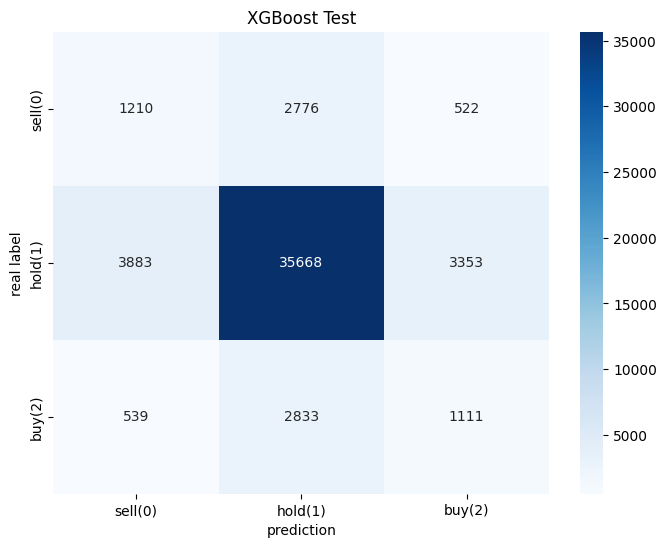

클래스별 정확도:
  sell(0): 0.2684
  hold(1): 0.8313
  buy(2): 0.2478


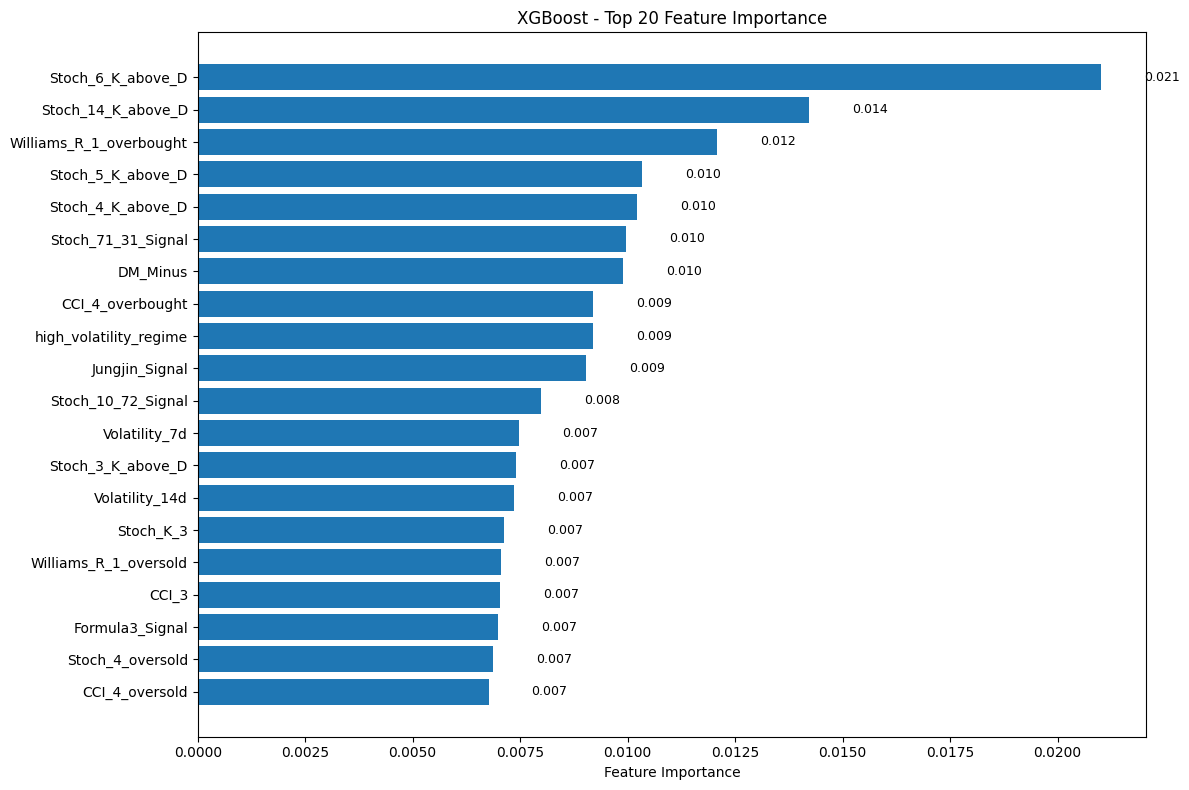

Top 20 중요 피쳐:
   1. Stoch_6_K_above_D: 0.0210
   2. Stoch_14_K_above_D: 0.0142
   3. Williams_R_1_overbought: 0.0121
   4. Stoch_5_K_above_D: 0.0103
   5. Stoch_4_K_above_D: 0.0102
   6. Stoch_71_31_Signal: 0.0100
   7. DM_Minus: 0.0099
   8. CCI_4_overbought: 0.0092
   9. high_volatility_regime: 0.0092
  10. Jungjin_Signal: 0.0090
  11. Stoch_10_72_Signal: 0.0080
  12. Volatility_7d: 0.0075
  13. Stoch_3_K_above_D: 0.0074
  14. Volatility_14d: 0.0074
  15. Stoch_K_3: 0.0071
  16. Williams_R_1_oversold: 0.0071
  17. CCI_3: 0.0070
  18. Formula3_Signal: 0.0070
  19. Stoch_4_oversold: 0.0069
  20. CCI_4_oversold: 0.0068


In [17]:
# =============================================================================
# 셀 9: 혼동 행렬 시각화
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, save_path=None):
    """혼동 행렬 시각화"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    
    # 정규화된 혼동 행렬도 표시
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 히트맵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['sell(0)', 'hold(1)', 'buy(2)'],
               yticklabels=['sell(0)', 'hold(1)', 'buy(2)'])
    plt.title('XGBoost Test')
    plt.xlabel('prediction')
    plt.ylabel('real label')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 클래스별 정확도
    print("클래스별 정확도:")
    for i, class_name in enumerate(['sell(0)', 'hold(1)', 'buy(2)']):
        accuracy = cm[i, i] / cm[i].sum()
        print(f"  {class_name}: {accuracy:.4f}")

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, test_predictions, 
                     save_path=os.path.join(output_dir, 'confusion_matrix.png'))

# =============================================================================
# 셀 10: 피쳐 중요도 시각화
# =============================================================================

def plot_feature_importance(feature_importance, top_n=20, save_path=None):
    """피쳐 중요도 시각화"""
    
    # 상위 N개 피쳐
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    features, importances = zip(*sorted_features)
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(features)), importances)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Feature Importance')
    plt.title(f'XGBoost - Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    
    # 값 표시
    for i, (bar, importance) in enumerate(zip(bars, importances)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 상위 피쳐들 출력
    print(f"Top {top_n} 중요 피쳐:")
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"  {i:2d}. {feature}: {importance:.4f}")

# 피쳐 중요도 시각화
plot_feature_importance(feature_importance, top_n=20, 
                       save_path=os.path.join(output_dir, 'feature_importance.png'))



# 피쳐별 성능파악 + 과적합찾기

In [18]:
# =============================================================================
# 데이터 누출 및 과적합 원인 진단 코드 (개선버전)
# =============================================================================

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def diagnose_data_leakage(train_df, val_df, test_df, feature_columns):
    """
    데이터 누출 및 과적합 원인 진단
    """
    print("="*60)
    print("데이터 누출 진단")
    print("="*60)
    
    # 1. Future 관련 피처가 실제로 제거되었는지 확인
    future_features = [col for col in feature_columns if 'Future' in col]
    if future_features:
        print(f"⚠️  경고: Future 관련 피처가 여전히 포함됨!")
        print(f"Future 피처들: {future_features}")
    else:
        print("✅ Future 관련 피처 모두 제거됨")
    
    # 2. 시간 정보 확인
    if 'Date' in train_df.columns:
        train_dates = pd.to_datetime(train_df['Date'])
        val_dates = pd.to_datetime(val_df['Date']) if not val_df.empty else None
        test_dates = pd.to_datetime(test_df['Date'])
        
        print(f"\n시간적 데이터 분포:")
        print(f"Train 기간: {train_dates.min()} ~ {train_dates.max()}")
        if val_dates is not None:
            print(f"Val 기간:   {val_dates.min()} ~ {val_dates.max()}")
        print(f"Test 기간:  {test_dates.min()} ~ {test_dates.max()}")
        
        # 시간적 순서 확인
        train_max = train_dates.max()
        test_min = test_dates.min()
        
        if test_min <= train_max:
            print(f"⚠️  심각한 문제: 테스트 데이터에 훈련 데이터보다 이른 날짜가 포함됨!")
            print(f"   Train 최대일: {train_max}")
            print(f"   Test 최소일: {test_min}")
            
            # 겹치는 날짜 확인
            overlapping_dates = set(train_dates.dt.date) & set(test_dates.dt.date)
            if overlapping_dates:
                print(f"   겹치는 날짜 수: {len(overlapping_dates)}개")
                print(f"   겹치는 날짜 샘플: {sorted(overlapping_dates)[:5]}")
        else:
            print("✅ 시간적 순서 올바름 (Train < Test)")
    
    # 3. 타겟 변수 분포 비교
    print(f"\n타겟 변수 분포 비교:")
    
    def print_distribution(name, y):
        dist = y.value_counts(normalize=True).sort_index() * 100
        print(f"{name:10s}: ", end="")
        for label in sorted(dist.index):
            print(f"{label}:{dist[label]:5.1f}% ", end="")
        print()
    
    print_distribution("Train", train_df['Future_Label'])
    if not val_df.empty:
        print_distribution("Val", val_df['Future_Label'])
    print_distribution("Test", test_df['Future_Label'])
    
    # 4. 특정 피처의 분포 확인 (누출 의심)
    suspicious_features = []
    for feature in feature_columns[:20]:  # 처음 20개 체크
        if feature in train_df.columns and feature in test_df.columns:
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            
            if abs(train_mean - test_mean) / (abs(train_mean) + 1e-8) > 2.0:  # 200% 이상 차이
                suspicious_features.append(feature)
    
    if suspicious_features:
        print(f"\n⚠️  분포가 크게 다른 피처들 (누출 의심):")
        for feature in suspicious_features[:10]:
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            print(f"   {feature}: Train={train_mean:.4f}, Test={test_mean:.4f}")
    
    # 5. 완전히 동일한 행이 있는지 확인
    print(f"\n데이터 중복 확인:")
    
    # 피처만으로 중복 확인
    train_features = train_df[feature_columns]
    test_features = test_df[feature_columns]
    
    # 해시를 이용한 빠른 중복 검사
    train_hashes = pd.util.hash_pandas_object(train_features, index=False)
    test_hashes = pd.util.hash_pandas_object(test_features, index=False)
    
    duplicate_count = len(set(train_hashes) & set(test_hashes))
    print(f"완전히 동일한 행 수: {duplicate_count}개")
    
    if duplicate_count > 0:
        print(f"⚠️  심각: Train과 Test에 동일한 행이 {duplicate_count}개 존재!")
    
    # 6. 심볼별 분포 확인 (주식 데이터인 경우)
    if 'Symbol' in train_df.columns and 'Symbol' in test_df.columns:
        train_symbols = set(train_df['Symbol'].unique())
        test_symbols = set(test_df['Symbol'].unique())
        common_symbols = train_symbols & test_symbols
        
        print(f"\nSymbol 분포:")
        print(f"Train 심볼 수: {len(train_symbols)}")
        print(f"Test 심볼 수: {len(test_symbols)}")
        print(f"공통 심볼 수: {len(common_symbols)}")
        
        if len(common_symbols) == 0:
            print("⚠️  경고: Train과 Test에 공통 심볼이 없음 (도메인 차이 가능성)")

    return {
        'future_features': future_features,
        'duplicate_rows': duplicate_count,
        'suspicious_features': suspicious_features
    }

# =============================================================================
# 다중공선성 분석 함수
# =============================================================================

def analyze_multicollinearity(X_data, feature_columns, max_features=50):
    """
    다중공선성(VIF) 분석
    """
    print("\n" + "="*60)
    print("다중공선성 분석 (VIF)")
    print("="*60)
    
    # 너무 많은 피처가 있으면 샘플링
    if len(feature_columns) > max_features:
        print(f"피처가 너무 많아서 상위 {max_features}개만 분석합니다.")
        # 분산이 큰 피처들을 우선적으로 선택
        feature_vars = X_data[feature_columns].var().sort_values(ascending=False)
        selected_features = feature_vars.head(max_features).index.tolist()
    else:
        selected_features = feature_columns
    
    # 결측값과 무한값 처리
    X_clean = X_data[selected_features].copy()
    X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
    X_clean = X_clean.fillna(X_clean.median())
    
    # 분산이 0인 피처 제거
    zero_var_features = X_clean.columns[X_clean.var() == 0].tolist()
    if zero_var_features:
        print(f"분산이 0인 피처 제거: {len(zero_var_features)}개")
        X_clean = X_clean.drop(columns=zero_var_features)
        selected_features = [f for f in selected_features if f not in zero_var_features]
    
    try:
        # VIF 계산
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_clean.columns
        vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) 
                          for i in range(len(X_clean.columns))]
        
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        # 높은 VIF 피처들 (다중공선성 문제)
        high_vif = vif_data[vif_data['VIF'] > 10]
        moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
        
        print("VIF 해석:")
        print("  VIF < 5: 다중공선성 문제 없음")
        print("  5 ≤ VIF ≤ 10: 중간 정도 다중공선성")
        print("  VIF > 10: 높은 다중공선성 (제거 고려)")
        print()
        
        if not high_vif.empty:
            print(f"⚠️  높은 다중공선성 피처들 (VIF > 10): {len(high_vif)}개")
            for idx, row in high_vif.head(15).iterrows():
                print(f"   {row['Feature']:30s}: VIF = {row['VIF']:8.2f}")
        
        if not moderate_vif.empty:
            print(f"\n중간 다중공선성 피처들 (5 < VIF ≤ 10): {len(moderate_vif)}개")
            for idx, row in moderate_vif.head(10).iterrows():
                print(f"   {row['Feature']:30s}: VIF = {row['VIF']:8.2f}")
        
        return vif_data
        
    except Exception as e:
        print(f"VIF 계산 중 오류 발생: {e}")
        print("상관관계로 대체 분석을 수행합니다.")
        
        # VIF 실패시 상관관계로 대체
        corr_matrix = X_clean.corr().abs()
        high_corr_pairs = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > 0.9:  # 높은 상관관계
                    high_corr_pairs.append((
                        corr_matrix.columns[i], 
                        corr_matrix.columns[j], 
                        corr_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            print(f"\n높은 상관관계 피처 쌍들 (>0.9): {len(high_corr_pairs)}개")
            for feat1, feat2, corr in high_corr_pairs[:10]:
                print(f"   {feat1} - {feat2}: {corr:.3f}")
        
        return None

# =============================================================================
# 과적합 원인 분석 함수 (개선버전)
# =============================================================================

def analyze_overfitting_causes(model, X_train_val, X_test, y_train_val, y_test, feature_columns):
    """
    과적합의 구체적 원인 분석 (Permutation Importance 포함)
    """
    print("\n" + "="*60)
    print("과적합 원인 분석")
    print("="*60)
    
    # 1. 피처 중요도 분석 (상위/하위 20개)
    feature_importance = model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("="*50)
    print("피처 중요도 분석")
    print("="*50)
    
    print("\n🔥 상위 20개 중요 피처:")
    for i, row in feature_imp_df.head(20).iterrows():
        print(f"  {i+1:2d}. {row['feature']:30s}: {row['importance']:.6f}")
    
    print("\n❄️  하위 20개 낮은 중요도 피처:")
    for i, row in feature_imp_df.tail(20).iterrows():
        rank = len(feature_imp_df) - list(feature_imp_df.index).index(i)
        print(f"  {rank:2d}. {row['feature']:30s}: {row['importance']:.6f}")
    
    # 2. 매우 높은 중요도를 가진 피처 확인 (누출 의심)
    high_importance_threshold = 0.05  # 5% 이상
    high_imp_features = feature_imp_df[feature_imp_df['importance'] > high_importance_threshold]
    
    if not high_imp_features.empty:
        print(f"\n⚠️  매우 높은 중요도 피처들 (>{high_importance_threshold:.1%}, 누출 의심):")
        for i, row in high_imp_features.iterrows():
            print(f"  {row['feature']:30s}: {row['importance']:.4f} ({row['importance']*100:.1f}%)")
    
    # 3. Permutation Importance 분석
    print("\n" + "="*50)
    print("Permutation Importance 분석")
    print("="*50)
    print("(성능이 오히려 향상되는 피처 = 악영향 피처)")
    
    try:
        # 기본 성능 측정
        y_pred_base = model.predict(X_test)
        base_score = accuracy_score(y_test, y_pred_base)
        print(f"기본 테스트 정확도: {base_score:.4f}")
        
        # Permutation importance 계산 (시간이 오래 걸릴 수 있음)
        print("Permutation importance 계산 중... (시간이 걸릴 수 있습니다)")
        
        # 샘플링을 통해 속도 개선
        n_sample = min(1000, len(X_test))
        sample_idx = np.random.choice(len(X_test), n_sample, replace=False)
        X_test_sample = X_test.iloc[sample_idx]
        y_test_sample = y_test.iloc[sample_idx] if hasattr(y_test, 'iloc') else y_test[sample_idx]
        
        perm_importance = permutation_importance(
            model, X_test_sample, y_test_sample, 
            n_repeats=3, random_state=42, 
            scoring='accuracy'
        )
        
        perm_imp_df = pd.DataFrame({
            'feature': feature_columns,
            'perm_importance_mean': perm_importance.importances_mean,
            'perm_importance_std': perm_importance.importances_std
        }).sort_values('perm_importance_mean', ascending=True)  # 낮은 순서로 정렬
        
        # 음의 영향을 주는 피처들 (permutation 시 성능이 향상되는 것들)
        negative_impact = perm_imp_df[perm_imp_df['perm_importance_mean'] < -0.001]
        
        if not negative_impact.empty:
            print(f"\n🚨 악영향 피처들 (제거시 성능 향상): {len(negative_impact)}개")
            for i, row in negative_impact.head(15).iterrows():
                impact = row['perm_importance_mean']
                std = row['perm_importance_std']
                print(f"  {row['feature']:30s}: {impact:+.4f} (±{std:.4f})")
        else:
            print("\n✅ 명확한 악영향 피처는 발견되지 않음")
        
        # 가장 중요한 피처들
        print(f"\n🌟 Permutation 기준 상위 15개 중요 피처:")
        for i, row in perm_imp_df.tail(15).iterrows():
            impact = row['perm_importance_mean']
            std = row['perm_importance_std']
            print(f"  {row['feature']:30s}: {impact:+.4f} (±{std:.4f})")
            
    except Exception as e:
        print(f"Permutation importance 계산 실패: {e}")
        print("대용량 데이터로 인한 메모리/시간 문제일 수 있습니다.")
    
    # 4. 모델 복잡도 확인
    print("\n" + "="*50)
    print("모델 복잡도 분석")
    print("="*50)
    
    if hasattr(model, 'get_params'):
        params = model.get_params()
        complex_params = ['max_depth', 'n_estimators', 'min_child_weight', 
                         'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']
        for param in complex_params:
            if param in params:
                print(f"  {param:20s}: {params[param]}")
    
    # 5. 데이터 분포 비교
    print(f"\n데이터 통계 비교:")
    train_stats = X_train_val.describe()
    test_stats = X_test.describe()
    
    print(f"{'통계':15s} {'Train':>12s} {'Test':>12s} {'차이':>12s}")
    print("-" * 55)
    for stat in ['mean', 'std', 'min', 'max']:
        train_val = train_stats.loc[stat].mean()
        test_val = test_stats.loc[stat].mean()
        diff = abs(train_val - test_val) / (abs(train_val) + 1e-8)
        print(f"{stat:15s} {train_val:12.4f} {test_val:12.4f} {diff:12.2%}")

    return feature_imp_df, perm_imp_df if 'perm_imp_df' in locals() else None

# =============================================================================
# 실행 코드
# =============================================================================

# 원본 데이터프레임들이 필요합니다
print("데이터 누출 진단을 위해 원본 데이터프레임을 다시 로드합니다...")

# 데이터 다시 로드 (진단용)
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))

# 1. 데이터 누출 진단
leakage_results = diagnose_data_leakage(train_df, val_df, test_df, feature_columns)

# 2. 다중공선성 분석
vif_results = analyze_multicollinearity(X_train_val, feature_columns)

# 3. 과적합 원인 분석 (Permutation Importance 포함)
feature_imp_results, perm_imp_results = analyze_overfitting_causes(
    final_model, X_train_val, X_test, y_train_val, y_test, feature_columns
)

print("\n" + "="*60)
print("진단 완료!")
print("="*60)
print("주요 발견사항:")
print(f"- Future 피처 수: {len(leakage_results['future_features'])}")
print(f"- 중복 행 수: {leakage_results['duplicate_rows']}")
print(f"- 의심스러운 피처 수: {len(leakage_results['suspicious_features'])}")
if vif_results is not None:
    high_vif_count = len(vif_results[vif_results['VIF'] > 10])
    print(f"- 높은 다중공선성 피처 수: {high_vif_count}")
print("\n상세한 분석 결과를 참고하여 피처를 선별하세요!")

데이터 누출 진단을 위해 원본 데이터프레임을 다시 로드합니다...
데이터 누출 진단
✅ Future 관련 피처 모두 제거됨

시간적 데이터 분포:
Train 기간: 2023-10-01 00:00:00 ~ 2025-02-16 17:00:00
Val 기간:   2025-02-16 17:00:00 ~ 2025-06-04 19:00:00
Test 기간:  2025-06-04 19:00:00 ~ 2025-09-20 23:00:00
✅ 시간적 순서 올바름 (Train < Test)

타겟 변수 분포 비교:
Train     : 0.0:  8.8% 1.0: 82.5% 2.0:  8.8% 
Val       : 0.0:  9.2% 1.0: 81.7% 2.0:  9.2% 
Test      : 0.0:  8.7% 1.0: 82.7% 2.0:  8.6% 

⚠️  분포가 크게 다른 피처들 (누출 의심):
   MA_2: Train=-0.0338, Test=0.1106
   MA_4: Train=-0.0338, Test=0.1106
   MA_6: Train=-0.0338, Test=0.1107
   MA_8: Train=-0.0338, Test=0.1107
   MA_13: Train=-0.0339, Test=0.1107
   MA_16: Train=-0.0339, Test=0.1108
   MA_20: Train=-0.0339, Test=0.1108
   MA_25: Train=-0.0339, Test=0.1109
   MA_29: Train=-0.0339, Test=0.1109
   MA_60: Train=-0.0341, Test=0.1113

데이터 중복 확인:
완전히 동일한 행 수: 0개

Symbol 분포:
Train 심볼 수: 20
Test 심볼 수: 20
공통 심볼 수: 20

다중공선성 분석 (VIF)
피처가 너무 많아서 상위 50개만 분석합니다.
VIF 해석:
  VIF < 5: 다중공선성 문제 없음
  5 ≤ VIF ≤ 10: 중간 정도 다중공선성
  VIF 

In [21]:
# =============================================================================
# 클래스 가중치 효과 분석 및 문제 진단
# =============================================================================

def analyze_class_weight_effect(model, X_train_val, X_test, y_train_val, y_test, class_weights):
    """
    클래스 가중치가 실제로 효과를 내고 있는지 분석
    """
    print("="*60)
    print("클래스 가중치 효과 분석")
    print("="*60)
    
    # 1. 예측 확률 분포 확인
    train_pred_proba = model.predict_proba(X_train_val)
    test_pred_proba = model.predict_proba(X_test)
    
    train_pred = model.predict(X_train_val)
    test_pred = model.predict(X_test)
    
    print("예측 결과 분포:")
    print(f"{'데이터셋':10s} {'Sell(0)':>8s} {'Hold(1)':>8s} {'Buy(2)':>8s}")
    print("-" * 40)
    
    # 실제 분포
    for name, y_true in [("실제-Train", y_train_val), ("실제-Test", y_test)]:
        counts = y_true.value_counts().sort_index()
        pcts = (counts / len(y_true) * 100)
        print(f"{name:10s} {pcts[0]:7.1f}% {pcts[1]:7.1f}% {pcts[2]:7.1f}%")
    
    # 예측 분포
    for name, y_pred in [("예측-Train", train_pred), ("예측-Test", test_pred)]:
        counts = pd.Series(y_pred).value_counts().sort_index()
        pcts = (counts / len(y_pred) * 100)
        
        # 누락된 클래스 처리
        for i in [0, 1, 2]:
            if i not in counts.index:
                counts[i] = 0
        counts = counts.sort_index()
        pcts = (counts / len(y_pred) * 100)
        
        print(f"{name:10s} {pcts[0]:7.1f}% {pcts[1]:7.1f}% {pcts[2]:7.1f}%")
    
    # 2. 예측 확률의 평균 확인
    print(f"\n평균 예측 확률:")
    print(f"{'데이터셋':10s} {'Sell(0)':>8s} {'Hold(1)':>8s} {'Buy(2)':>8s}")
    print("-" * 40)
    
    train_prob_mean = train_pred_proba.mean(axis=0)
    test_prob_mean = test_pred_proba.mean(axis=0)
    
    print(f"{'Train':10s} {train_prob_mean[0]:8.3f} {train_prob_mean[1]:8.3f} {train_prob_mean[2]:8.3f}")
    print(f"{'Test':10s} {test_prob_mean[0]:8.3f} {test_prob_mean[1]:8.3f} {test_prob_mean[2]:8.3f}")
    
    # 3. 클래스별 성능 상세 분석
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\n테스트 세트 상세 성능:")
    print(classification_report(y_test, test_pred, 
                              target_names=['Sell(0)', 'Hold(1)', 'Buy(2)']))
    
    print(f"테스트 세트 혼동 행렬:")
    cm = confusion_matrix(y_test, test_pred)
    print(f"{'':8s} {'Sell':>6s} {'Hold':>6s} {'Buy':>6s}")
    class_names = ['Sell', 'Hold', 'Buy']
    for i, row_name in enumerate(class_names):
        print(f"{row_name:8s}", end="")
        for j in range(3):
            print(f"{cm[i,j]:6d}", end="")
        print()
    
    # 4. 클래스 가중치가 제대로 작동하는지 확인
    print(f"\n클래스 가중치 효과 분석:")
    print(f"설정된 가중치: {class_weights}")
    
    # 실제 손실에서 클래스별 기여도 추정
    # (정확한 계산은 모델 내부 접근이 필요하지만, 대략적 추정)
    
    # 만약 모든 클래스를 Hold로 예측했다면?
    naive_pred = np.ones_like(y_test)  # 모든 것을 Hold(1)로 예측
    naive_accuracy = accuracy_score(y_test, naive_pred)
    actual_accuracy = accuracy_score(y_test, test_pred)
    
    print(f"Naive 예측 (모두 Hold): {naive_accuracy:.4f}")
    print(f"실제 모델 정확도: {actual_accuracy:.4f}")
    print(f"개선 정도: {actual_accuracy - naive_accuracy:.4f}")
    
    if actual_accuracy - naive_accuracy < 0.01:  # 1% 미만 개선
        print("⚠️ 경고: 클래스 가중치가 거의 효과를 내지 못하고 있음!")
        return False
    else:
        print("✅ 클래스 가중치가 어느 정도 효과를 내고 있음")
        return True

# =============================================================================
# 더 강력한 클래스 불균형 해결 방법들
# =============================================================================

def suggest_improved_approaches():
    """
    클래스 불균형 문제에 대한 더 강력한 해결책들
    """
    print(f"\n" + "="*60)
    print("클래스 불균형 문제 - 개선된 해결책들")
    print("="*60)
    
    print("1. 더 강한 클래스 가중치 사용:")
    print("   - 현재 가중치를 2-3배 더 강하게 설정")
    print("   - sklearn의 'balanced' 옵션 사용")
    
    print("\n2. 샘플링 기법 적용:")
    print("   - SMOTE: 소수 클래스 오버샘플링")
    print("   - RandomUnderSampler: 다수 클래스 언더샘플링")
    print("   - 조합 방법 (SMOTEENN, SMOTETomek)")
    
    print("\n3. 임계값(Threshold) 조정:")
    print("   - 기본 0.5 대신 클래스별 최적 임계값 찾기")
    print("   - Precision-Recall 커브 활용")
    
    print("\n4. 평가 지표 변경:")
    print("   - Accuracy 대신 Macro F1-Score 사용")
    print("   - 클래스별 F1-Score 개별 확인")
    print("   - Balanced Accuracy 사용")
    
    print("\n5. 앙상블 방법:")
    print("   - BalancedRandomForest")
    print("   - EasyEnsemble")
    print("   - 클래스별 별도 모델 학습")

# =============================================================================
# 강화된 클래스 가중치 실험
# =============================================================================

def train_with_stronger_weights(X_train_val, y_train_val, best_params):
    """
    더 강한 클래스 가중치로 모델 재학습
    """
    print(f"\n" + "="*60)
    print("강화된 클래스 가중치로 재학습")
    print("="*60)
    
    # 1. sklearn의 'balanced' 옵션 시도
    print("1. sklearn 'balanced' 가중치 실험...")
    
    balanced_params = {
        **best_params,
        'objective': 'multi:softprob',
        'num_class': 3,
        'random_state': RANDOM_STATE,
        'eval_metric': 'mlogloss'
    }
    
    # XGBoost는 class_weight를 직접 지원하지 않으므로 sample_weight 사용
    from sklearn.utils.class_weight import compute_sample_weight
    
    # 'balanced' 옵션으로 샘플 가중치 계산
    sample_weights_balanced = compute_sample_weight('balanced', y_train_val)
    
    print(f"Balanced 샘플 가중치 통계:")
    print(f"  평균: {sample_weights_balanced.mean():.3f}")
    print(f"  최소: {sample_weights_balanced.min():.3f}")
    print(f"  최대: {sample_weights_balanced.max():.3f}")
    print(f"  비율 (최대/최소): {sample_weights_balanced.max()/sample_weights_balanced.min():.1f}")
    
    # 2. 수동으로 더 강한 가중치 설정
    print(f"\n2. 수동 강화 가중치 실험...")
    
    # 기존 가중치의 2배로 극값 강화
    enhanced_weights = {
        0: 15.0,  # Sell - 더 강하게
        1: 0.2,   # Hold - 더 약하게  
        2: 15.0   # Buy - 더 강하게
    }
    
    sample_weights_enhanced = np.array([enhanced_weights[label] for label in y_train_val])
    
    print(f"강화된 클래스 가중치: {enhanced_weights}")
    print(f"강화된 샘플 가중치 통계:")
    print(f"  평균: {sample_weights_enhanced.mean():.3f}")
    print(f"  최소: {sample_weights_enhanced.min():.3f}")
    print(f"  최대: {sample_weights_enhanced.max():.3f}")
    print(f"  비율 (최대/최소): {sample_weights_enhanced.max()/sample_weights_enhanced.min():.1f}")
    
    return sample_weights_balanced, sample_weights_enhanced, balanced_params

# =============================================================================
# 실행 코드
# =============================================================================

# 현재 모델의 클래스 가중치 효과 분석
print("현재 모델의 클래스 가중치 효과를 분석합니다...")
weight_is_effective = analyze_class_weight_effect(
    final_model, X_train_val, X_test, y_train_val, y_test, class_weights
)

# 개선 방법 제안
suggest_improved_approaches()

# 더 강한 가중치로 실험할 준비
if not weight_is_effective:
    print(f"\n클래스 가중치 효과가 부족합니다. 더 강한 방법을 시도해보세요.")
    sample_weights_balanced, sample_weights_enhanced, enhanced_params = train_with_stronger_weights(
        X_train_val, y_train_val, best_params
    )
    
    print(f"\n다음 단계:")
    print(f"1. 위의 강화된 가중치로 모델을 다시 학습")
    print(f"2. SMOTE 등 샘플링 기법 적용")
    print(f"3. 임계값 조정으로 예측 최적화")
else:
    print(f"\n클래스 가중치가 효과를 내고 있지만, 추가 개선이 필요할 수 있습니다.")

현재 모델의 클래스 가중치 효과를 분석합니다...
클래스 가중치 효과 분석
예측 결과 분포:
데이터셋        Sell(0)  Hold(1)   Buy(2)
----------------------------------------
실제-Train       8.8%    82.3%     8.8%
실제-Test        8.7%    82.7%     8.6%
예측-Train      15.2%    69.8%    15.0%
예측-Test       10.9%    79.5%     9.6%

평균 예측 확률:
데이터셋        Sell(0)  Hold(1)   Buy(2)
----------------------------------------
Train         0.235    0.532    0.233
Test          0.216    0.572    0.212

테스트 세트 상세 성능:
              precision    recall  f1-score   support

     Sell(0)       0.21      0.27      0.24      4508
     Hold(1)       0.86      0.83      0.85     42904
      Buy(2)       0.22      0.25      0.23      4483

    accuracy                           0.73     51895
   macro avg       0.43      0.45      0.44     51895
weighted avg       0.75      0.73      0.74     51895

테스트 세트 혼동 행렬:
           Sell   Hold    Buy
Sell      1210  2776   522
Hold      3883 35668  3353
Buy        539  2833  1111

클래스 가중치 효과 분석:
설정된 가중치: {0.0:

In [22]:
# =============================================================================
# 셀 11: 결과 저장
# =============================================================================

# =============================================================================
# 셀 11: 결과 저장 (수정)
# =============================================================================
def save_results(model, best_params, evaluation_results, feature_importance, output_dir):
    """결과 저장 (JSON 직렬화 문제 해결)"""
    
    print("결과 저장 중...")
    
    # 모델 저장
    model_path = os.path.join(output_dir, 'xgboost_model.pkl')
    joblib.dump(model, model_path)
    print(f"  모델 저장: {model_path}")
    
    # 최적 하이퍼파라미터 저장
    params_path = os.path.join(output_dir, 'xgboost_best_params.json')
    with open(params_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    print(f"  최적 파라미터 저장: {params_path}")
    
    # 평가 결과 저장 (numpy 타입 변환)
    results_path = os.path.join(output_dir, 'xgboost_results.json')
    evaluation_results_serializable = {}
    for key, value in evaluation_results.items():
        if isinstance(value, dict):
            evaluation_results_serializable[key] = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                                                   for k, v in value.items()}
        else:
            evaluation_results_serializable[key] = float(value) if isinstance(value, (np.float32, np.float64)) else value
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_results_serializable, f, indent=2)
    print(f"  평가 결과 저장: {results_path}")
    
    # 피쳐 중요도 저장 (float32 → float 변환)
    importance_path = os.path.join(output_dir, 'xgboost_feature_importance.json')
    feature_importance_serializable = {k: float(v) for k, v in feature_importance.items()}
    with open(importance_path, 'w') as f:
        json.dump(feature_importance_serializable, f, indent=2)
    print(f"  피쳐 중요도 저장: {importance_path}")
    
    # 피쳐 리스트 저장
    features_path = os.path.join(output_dir, 'feature_list.json')
    with open(features_path, 'w') as f:
        json.dump({
            'feature_count': len(feature_columns),
            'feature_list': feature_columns
        }, f, indent=2)
    print(f"  피쳐 리스트 저장: {features_path}")

# 결과 저장 실행
save_results(final_model, best_params, evaluation_results, feature_importance, output_dir)

# =============================================================================
# 셀 12: 최종 요약
# =============================================================================

print("\n" + "="*80)
print("XGBoost 주식 3진분류 모델 학습 완료")
print("="*80)

print(f"완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"최종 테스트 F1-Score: {evaluation_results['Test']['f1_macro']:.4f}")
print(f"최종 테스트 정확도: {evaluation_results['Test']['accuracy']:.4f}")
print(f"CV F1-Score: {evaluation_results['CV_F1_Score']:.4f}")
# print(f"과적합 정도: {evaluation_results['Overfitting']:.4f}")

print(f"\n저장된 파일들:")
print(f"  - 모델: {output_dir}/xgboost_model.pkl")
print(f"  - 하이퍼파라미터: {output_dir}/xgboost_best_params.json")
print(f"  - 평가 결과: {output_dir}/xgboost_results.json")
print(f"  - 피쳐 중요도: {output_dir}/xgboost_feature_importance.json")

print("\n다음 단계: CatBoost 모델 학습 또는 모델 앙상블")
print("="*80)

결과 저장 중...
  모델 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_model.pkl
  최적 파라미터 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_best_params.json
  평가 결과 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_results.json
  피쳐 중요도 저장: /workspace/AI모델/projects/coin/models/1h/xgboost_feature_importance.json
  피쳐 리스트 저장: /workspace/AI모델/projects/coin/models/1h/feature_list.json

XGBoost 주식 3진분류 모델 학습 완료
완료 시간: 2025-09-22 20:34:10
최종 테스트 F1-Score: 0.4402
최종 테스트 정확도: 0.7320
CV F1-Score: 0.4361

저장된 파일들:
  - 모델: /workspace/AI모델/projects/coin/models/1h/xgboost_model.pkl
  - 하이퍼파라미터: /workspace/AI모델/projects/coin/models/1h/xgboost_best_params.json
  - 평가 결과: /workspace/AI모델/projects/coin/models/1h/xgboost_results.json
  - 피쳐 중요도: /workspace/AI모델/projects/coin/models/1h/xgboost_feature_importance.json

다음 단계: CatBoost 모델 학습 또는 모델 앙상블


In [23]:
output_dir

'/workspace/AI모델/projects/coin/models/1h'

# 최종테스트 + 백테스팅용 데이터 만들기

In [24]:
### test  full data 만들기 - date, close 등등 모두포함
# 학습용 전체데이터 (Train+Val+Test)로드 후 test set범위만 추출
train_path = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/xgboost_training_data.csv'
full_data = pd.read_csv(train_path)

# 시계열 순서에 맞게 추출
full_data = full_data.sort_values('Date')

# 기존 C00_00코드에서 split_time_series_data() 함수와 동일한 비율(70:15:15)로 분할점 계산
# test set범위만 추출
n = len(full_data)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
test_data_full = full_data.iloc[val_end:].copy()

# test(피쳐 다 있는 버전) set 저장
test_output_path = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/test_data_full.csv'
test_data_full.to_csv(test_output_path, index=False)

# 날짜 : 2021.09.13~, 종목 : CVX 행부터 나오면 됨 : C00_00 스크립트 참고

In [25]:
# =============================================================================
# 백테스팅 1단계: 데이터 로드 및 예측 실행
# =============================================================================

import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("백테스팅 1단계: 데이터 로드 및 예측 실행")
print("=" * 60)

# 1. test_data_full.csv 로드 (윗 셀에서 생성)
test_data_full_path = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/test_data_full.csv'
test_data_full = pd.read_csv(test_data_full_path)

print(f"테스트 데이터 로드 완료: {test_data_full.shape}")
print(f"날짜 범위: {test_data_full['Date'].min()} ~ {test_data_full['Date'].max()}")
print(f"종목 수: {test_data_full['Symbol'].nunique()}")
print(f"종목 리스트: {test_data_full['Symbol'].unique()}")

# 2. Prediction을 위해, 학습시 사용했던 피쳐만 추출 (이미 셀3에서 정의한 feature_columns 사용)
print(f"\n학습용 피쳐 추출...")
print(f"전체 컬럼 수: {len(test_data_full.columns)}")
print(f"사용할 피쳐 수: {len(feature_columns)}")


백테스팅 1단계: 데이터 로드 및 예측 실행
테스트 데이터 로드 완료: (51895, 389)
날짜 범위: 2025-06-04 19:00:00 ~ 2025-09-20 23:00:00
종목 수: 20
종목 리스트: ['USDC' 'SOL' 'HBAR' 'TON11419' 'ETH' 'TRX' 'XRP' 'SHIB' 'LEO' 'AVAX'
 'XLM' 'USDT' 'SUI20947' 'LTC' 'ADA' 'CRO' 'BTC' 'DOGE' 'BCH' 'BNB']

학습용 피쳐 추출...
전체 컬럼 수: 389
사용할 피쳐 수: 198


## 모델예측(최종test)

In [26]:

# 피쳐 데이터 준비
X_backtest = test_data_full[feature_columns].fillna(0)
X_backtest = X_backtest.replace([np.inf, -np.inf], 0)

print(f"백테스팅용 피쳐 데이터: {X_backtest.shape}")

# 3. 모델로 예측 실행
print(f"\n예측 실행 중...")

# 라벨예측
predictions = final_model.predict(X_backtest)
# 형태: NumPy 1D 배열
# 예시: array([1, 2, 0, 1, 2, 0, ...])  # 길이 = 샘플 수 : (12543,) 같은 형태

# 확률예측
prediction_probabilities = final_model.predict_proba(X_backtest) # (12543, 3) 같은 형태
# 형태: NumPy 2D 배열 (샘플 수 × 클래스 수)
# 예시: array([[0.2, 0.7, 0.1],   # 첫 번째 샘플: Sell=0.2, Hold=0.7, Buy=0.1
#              [0.1, 0.3, 0.6],   # 두 번째 샘플: Sell=0.1, Hold=0.3, Buy=0.6
#              ...])

print(f"예측 완료!")
print(f"예측 결과 분포:")
unique, counts = np.unique(predictions, return_counts=True)
for label, count in zip(unique, counts):
    label_name = {0: 'Sell', 1: 'Hold', 2: 'Buy'}[int(label)]
    pct = count / len(predictions) * 100
    print(f"  {int(label)} ({label_name}): {count:,}개 ({pct:.1f}%)")

백테스팅용 피쳐 데이터: (51895, 198)

예측 실행 중...
예측 완료!
예측 결과 분포:
  0 (Sell): 5,632개 (10.9%)
  1 (Hold): 41,277개 (79.5%)
  2 (Buy): 4,986개 (9.6%)


In [27]:

# 4. 예측 결과를 원본 데이터에 추가
# 1D 배열을 데이터프레임 컬럼으로 추가
test_data_full['Predicted_Label'] = predictions

# 2D 배열에서 각 클래스별로 컬럼 추가
test_data_full['Pred_Prob_Sell'] = prediction_probabilities[:, 0]
test_data_full['Pred_Prob_Hold'] = prediction_probabilities[:, 1]
test_data_full['Pred_Prob_Buy'] = prediction_probabilities[:, 2]

# 예측 신호를 텍스트로 변환
label_map = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
test_data_full['Predicted_Action'] = test_data_full['Predicted_Label'].map(label_map)

print(f"\n예측 결과가 추가된 데이터: {test_data_full.shape}")

# 5. 실제 라벨과 비교 (검증용)
if 'Future_Label' in test_data_full.columns:
    actual_labels = test_data_full['Future_Label']
    test_accuracy = accuracy_score(actual_labels, predictions)
    test_f1 = f1_score(actual_labels, predictions, average='macro')
    
    print(f"\n예측 성능 검증:")
    print(f"  정확도: {test_accuracy:.4f}")
    print(f"  F1 Score: {test_f1:.4f}")
    
    print(f"\n상세 분류 보고서:")
    print(classification_report(actual_labels, predictions, 
                               target_names=['Sell', 'Hold', 'Buy']))

# 6. 예측 결과가 추가된 전체 데이터 저장
output_path = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/test_data_with_predictions.csv'
test_data_full.to_csv(output_path, index=False)
print(f"\n예측 결과가 추가된 데이터 저장: {output_path}")

# 7. 백테스팅용 핵심 데이터만 추출
backtest_data = test_data_full[['Date', 'Symbol', 'Close', 'Predicted_Label', 
                               'Predicted_Action', 'Pred_Prob_Sell', 
                               'Pred_Prob_Hold', 'Pred_Prob_Buy']].copy()

# Date 컬럼을 datetime으로 변환
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

# 시간순 정렬
backtest_data = backtest_data.sort_values(['Symbol', 'Date']).reset_index(drop=True)

print(f"\n백테스팅용 데이터 준비 완료: {backtest_data.shape}")
print(f"샘플 데이터:")
print(backtest_data.head(10))

# 8. 백테스팅용 간단 데이터도 별도 저장
simple_backtest_path = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/only_prediction_data.csv'
backtest_data.to_csv(simple_backtest_path, index=False)
print(f"백테스팅용 간단 데이터 저장: {simple_backtest_path}")

print(f"\n1단계 완료!")


예측 결과가 추가된 데이터: (51895, 394)

예측 성능 검증:
  정확도: 0.7320
  F1 Score: 0.4402

상세 분류 보고서:
              precision    recall  f1-score   support

        Sell       0.21      0.27      0.24      4508
        Hold       0.86      0.83      0.85     42904
         Buy       0.22      0.25      0.23      4483

    accuracy                           0.73     51895
   macro avg       0.43      0.45      0.44     51895
weighted avg       0.75      0.73      0.74     51895


예측 결과가 추가된 데이터 저장: /workspace/AI모델/projects/coin/data/1h/xgboost_B/test_data_with_predictions.csv

백테스팅용 데이터 준비 완료: (51895, 8)
샘플 데이터:
                 Date Symbol     Close  Predicted_Label Predicted_Action  \
0 2025-06-04 20:00:00    ADA  0.667680                1             Hold   
1 2025-06-04 21:00:00    ADA  0.672527                1             Hold   
2 2025-06-04 22:00:00    ADA  0.667194                1             Hold   
3 2025-06-04 23:00:00    ADA  0.665905                1             Hold   
4 2025-06-05 00:0

In [28]:
display(test_data_full.head(5))
display(test_data_full.tail(5))

,Open,High,Low,Close,Volume,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_10,MA_13,MA_16,MA_20,MA_25,MA_29,MA_50,MA_60,MA_100,MA_120,MA_200,EMA_3,EMA_4,EMA_5,EMA_6,EMA_7,EMA_10,EMA_12,EMA_20,EMA_24,EMA_26,EMA_50,MACD,MACD_Signal,MACD_Histogram,MACD_10_20,MACD_10_20_Signal,MACD_15_26,MACD_15_26_Signal,MACD_5_27,MACD_5_27_Signal,RSI_4,RSI_5,RSI_6,RSI_7,RSI_12,RSI_14,RSI_20,RSI_21,BB_Middle_20,BB_Upper_20,BB_Lower_20,BB_Width_20,BB_Position_20,Return_1d,Return_3d,Return_7d,Return_14d,Return_30d,Return_90d,Return_180d,Return_365d,Cumulative_Return,Volatility_7d,Volatility_14d,Volatility_30d,Volatility_90d,Volume_MA_7,Volume_MA_20,Volume_MA_50,Volume_Ratio,Volume_Price_Trend,True_Range,ATR_14,ATR_Percent_14,Stoch_K_1,Stoch_D_1,Stoch_K_3,Stoch_D_3,Stoch_K_4,Stoch_D_4,Stoch_K_5,Stoch_D_5,Stoch_K_6,Stoch_D_6,Stoch_K_14,Stoch_D_14,Williams_R_1,Williams_R_8,Williams_R_10,Williams_R_14,Williams_R,CCI_3,CCI_4,CCI_10,CCI_17,CCI_20,CCI,MFI_11,MFI_14,MFI,OSCP_11_36,OSCP_18_19,OSCP_19_20,TR,DM_Plus,DM_Minus,DI_Plus_21,DI_Minus_21,ADX_21,Price_ROC_3,STD_1,STD_20,Highest_3,Lowest_3,Highest_7,Lowest_7,Highest_8,Lowest_8,Highest_10,Lowest_10,Highest_11,Lowest_11,Highest_16,Lowest_16,Highest_17,Lowest_17,Highest_28,Lowest_28,Price_vs_MA7,Price_vs_MA20,Price_vs_MA50,Price_vs_MA100,Price_vs_MA200,HighLow_Position_52d,HighLow_Position_200d,MA_Cross_3_25_Signal,MA_Trend_Signal,EMA_Cross_5_20_Signal,EMA_Cross_6_24_Signal,Jungjin_Signal,MACD_Zero_Cross_Signal,MACD_Signal_Cross,Bad_Market3_Signal,RSI_Reversal_Signal,RSI_Extreme_Signal,RSI_Reverse_Signal,RSI_20_75_Signal,RSI_22_78_Signal,RSI_30_65_Signal,RSI_12_50_Signal,Williams_CCI_Signal,CCI_Oversold_Signal,CCI_3_Signal,Stoch_RSI_Combo_Signal,Stoch_10_72_Signal,Stoch_71_31_Signal,Candlestick_Signal,Formula3_Signal,Shadow_Analysis_Signal,Pivot,Support1,Resistance1,Pivot_Strategy_Signal,MFI_Strategy_Signal,MFI_25_50_Signal,MFI_Extreme_Signal,Volume_Breakout_Signal,Momentum_Signal,Price_ROC_3_Signal,Volatility_Signal,Composite_Signal_Avg,Buy_Signal_Count,Sell_Signal_Count,Net_Signal_Score,Final_Composite_Signal,Price_Momentum_5,Price_Momentum_10,Price_Momentum_20,Volatility_20,Volatility_Ratio,RSI_Divergence,MACD_Cross,Support_Level,Resistance_Level,Price_Position,Technical_Score,Enhanced_Technical_Score,Composite_Score,Future_1d,Future_3d,Future_7d,Future_14d,Future_30d,Future_90d,Future_180d,Future_365d,Label,Label_Name,Optimized_Label,Optimized_Label_Name,Close_log_return,Close_return,Open_log_return,Open_return,High_log_return,High_return,Low_log_return,Low_return,MA_2_ratio,MA_2_distance,MA_3_ratio,MA_3_distance,MA_4_ratio,MA_4_distance,MA_5_ratio,MA_5_distance,MA_6_ratio,MA_6_distance,MA_7_ratio,MA_7_distance,MA_8_ratio,MA_8_distance,MA_10_ratio,MA_10_distance,MA_13_ratio,MA_13_distance,MA_16_ratio,MA_16_distance,MA_20_ratio,MA_20_distance,MA_25_ratio,MA_25_distance,MA_29_ratio,MA_29_distance,MA_50_ratio,MA_50_distance,MA_60_ratio,MA_60_distance,MA_100_ratio,MA_100_distance,MA_120_ratio,MA_120_distance,MA_200_ratio,MA_200_distance,MA_Cross_3_25_Signal_ratio,MA_Cross_3_25_Signal_distance,MA_Trend_Signal_ratio,MA_Trend_Signal_distance,EMA_3_ratio,EMA_4_ratio,EMA_5_ratio,EMA_6_ratio,EMA_7_ratio,EMA_10_ratio,EMA_12_ratio,EMA_20_ratio,EMA_24_ratio,EMA_26_ratio,EMA_50_ratio,EMA_Cross_5_20_Signal_ratio,EMA_Cross_6_24_Signal_ratio,BB_relative_position,BB_upper_distance,BB_lower_distance,Volume_normalized,Volume_log_ratio,RSI_4_overbought,RSI_4_oversold,RSI_4_normalized,RSI_5_overbought,RSI_5_oversold,RSI_5_normalized,RSI_6_overbought,RSI_6_oversold,RSI_6_normalized,RSI_7_overbought,RSI_7_oversold,RSI_7_normalized,RSI_12_overbought,RSI_12_oversold,RSI_12_normalized,RSI_14_overbought,RSI_14_oversold,RSI_14_normalized,RSI_20_overbought,RSI_20_oversold,RSI_20_normalized,RSI_21_overbought,RSI_21_oversold,RSI_21_normalized,RSI_Reversal_Signal_overbought,RSI_Reversal_Signal_oversold,RSI_Reversal_Signal_normalized,RSI_Extreme_Signal_overbought,RSI_Extreme_Signal_oversold,RSI_Extreme_Signal_normalized,RSI_Reverse_Signal_ove

,Open,High,Low,Close,Volume,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_10,MA_13,MA_16,MA_20,MA_25,MA_29,MA_50,MA_60,MA_100,MA_120,MA_200,EMA_3,EMA_4,EMA_5,EMA_6,EMA_7,EMA_10,EMA_12,EMA_20,EMA_24,EMA_26,EMA_50,MACD,MACD_Signal,MACD_Histogram,MACD_10_20,MACD_10_20_Signal,MACD_15_26,MACD_15_26_Signal,MACD_5_27,MACD_5_27_Signal,RSI_4,RSI_5,RSI_6,RSI_7,RSI_12,RSI_14,RSI_20,RSI_21,BB_Middle_20,BB_Upper_20,BB_Lower_20,BB_Width_20,BB_Position_20,Return_1d,Return_3d,Return_7d,Return_14d,Return_30d,Return_90d,Return_180d,Return_365d,Cumulative_Return,Volatility_7d,Volatility_14d,Volatility_30d,Volatility_90d,Volume_MA_7,Volume_MA_20,Volume_MA_50,Volume_Ratio,Volume_Price_Trend,True_Range,ATR_14,ATR_Percent_14,Stoch_K_1,Stoch_D_1,Stoch_K_3,Stoch_D_3,Stoch_K_4,Stoch_D_4,Stoch_K_5,Stoch_D_5,Stoch_K_6,Stoch_D_6,Stoch_K_14,Stoch_D_14,Williams_R_1,Williams_R_8,Williams_R_10,Williams_R_14,Williams_R,CCI_3,CCI_4,CCI_10,CCI_17,CCI_20,CCI,MFI_11,MFI_14,MFI,OSCP_11_36,OSCP_18_19,OSCP_19_20,TR,DM_Plus,DM_Minus,DI_Plus_21,DI_Minus_21,ADX_21,Price_ROC_3,STD_1,STD_20,Highest_3,Lowest_3,Highest_7,Lowest_7,Highest_8,Lowest_8,Highest_10,Lowest_10,Highest_11,Lowest_11,Highest_16,Lowest_16,Highest_17,Lowest_17,Highest_28,Lowest_28,Price_vs_MA7,Price_vs_MA20,Price_vs_MA50,Price_vs_MA100,Price_vs_MA200,HighLow_Position_52d,HighLow_Position_200d,MA_Cross_3_25_Signal,MA_Trend_Signal,EMA_Cross_5_20_Signal,EMA_Cross_6_24_Signal,Jungjin_Signal,MACD_Zero_Cross_Signal,MACD_Signal_Cross,Bad_Market3_Signal,RSI_Reversal_Signal,RSI_Extreme_Signal,RSI_Reverse_Signal,RSI_20_75_Signal,RSI_22_78_Signal,RSI_30_65_Signal,RSI_12_50_Signal,Williams_CCI_Signal,CCI_Oversold_Signal,CCI_3_Signal,Stoch_RSI_Combo_Signal,Stoch_10_72_Signal,Stoch_71_31_Signal,Candlestick_Signal,Formula3_Signal,Shadow_Analysis_Signal,Pivot,Support1,Resistance1,Pivot_Strategy_Signal,MFI_Strategy_Signal,MFI_25_50_Signal,MFI_Extreme_Signal,Volume_Breakout_Signal,Momentum_Signal,Price_ROC_3_Signal,Volatility_Signal,Composite_Signal_Avg,Buy_Signal_Count,Sell_Signal_Count,Net_Signal_Score,Final_Composite_Signal,Price_Momentum_5,Price_Momentum_10,Price_Momentum_20,Volatility_20,Volatility_Ratio,RSI_Divergence,MACD_Cross,Support_Level,Resistance_Level,Price_Position,Technical_Score,Enhanced_Technical_Score,Composite_Score,Future_1d,Future_3d,Future_7d,Future_14d,Future_30d,Future_90d,Future_180d,Future_365d,Label,Label_Name,Optimized_Label,Optimized_Label_Name,Close_log_return,Close_return,Open_log_return,Open_return,High_log_return,High_return,Low_log_return,Low_return,MA_2_ratio,MA_2_distance,MA_3_ratio,MA_3_distance,MA_4_ratio,MA_4_distance,MA_5_ratio,MA_5_distance,MA_6_ratio,MA_6_distance,MA_7_ratio,MA_7_distance,MA_8_ratio,MA_8_distance,MA_10_ratio,MA_10_distance,MA_13_ratio,MA_13_distance,MA_16_ratio,MA_16_distance,MA_20_ratio,MA_20_distance,MA_25_ratio,MA_25_distance,MA_29_ratio,MA_29_distance,MA_50_ratio,MA_50_distance,MA_60_ratio,MA_60_distance,MA_100_ratio,MA_100_distance,MA_120_ratio,MA_120_distance,MA_200_ratio,MA_200_distance,MA_Cross_3_25_Signal_ratio,MA_Cross_3_25_Signal_distance,MA_Trend_Signal_ratio,MA_Trend_Signal_distance,EMA_3_ratio,EMA_4_ratio,EMA_5_ratio,EMA_6_ratio,EMA_7_ratio,EMA_10_ratio,EMA_12_ratio,EMA_20_ratio,EMA_24_ratio,EMA_26_ratio,EMA_50_ratio,EMA_Cross_5_20_Signal_ratio,EMA_Cross_6_24_Signal_ratio,BB_relative_position,BB_upper_distance,BB_lower_distance,Volume_normalized,Volume_log_ratio,RSI_4_overbought,RSI_4_oversold,RSI_4_normalized,RSI_5_overbought,RSI_5_oversold,RSI_5_normalized,RSI_6_overbought,RSI_6_oversold,RSI_6_normalized,RSI_7_overbought,RSI_7_oversold,RSI_7_normalized,RSI_12_overbought,RSI_12_oversold,RSI_12_normalized,RSI_14_overbought,RSI_14_oversold,RSI_14_normalized,RSI_20_overbought,RSI_20_oversold,RSI_20_normalized,RSI_21_overbought,RSI_21_oversold,RSI_21_normalized,RSI_Reversal_Signal_overbought,RSI_Reversal_Signal_oversold,RSI_Reversal_Signal_normalized,RSI_Extreme_Signal_overbought,RSI_Extreme_Signal_oversold,RSI_Extreme_Signal_normalized,RSI_Reverse_Signal_ove

# 종목별 저장 : 예측컬럼이 포함된 csv 종목별로 저장

In [29]:
# =============================================================================
# 종목별 예측 결과 CSV 파일 생성
# =============================================================================

import pandas as pd
import os

print("종목별 예측 결과 CSV 파일 생성")
print("=" * 60)

# 1. backtest_data 로드 
# backtest_data가 없다면 아래 주석 해제
backtest_data_path = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/test_data_with_predictions.csv'
backtest_data = pd.read_csv(backtest_data_path)
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

종목별 예측 결과 CSV 파일 생성


In [30]:
# 원본 백테스팅 데이터 경로
backtest_dir = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/backtest_data'

# 이 폴더에는 각 종목별로 원본 Close 가격이 저장되어 있음:
# AAPL_backtest.csv, MSFT_backtest.csv 등...

In [31]:
import pandas as pd
import os
import glob

# 1. 예측 데이터 로드
prediction_data = pd.read_csv('/workspace/AI모델/projects/coin/data/1h/xgboost_B/test_data_with_predictions.csv')
prediction_cols = ['Date', 'Symbol', 'Predicted_Label', 'Predicted_Action', 'Pred_Prob_Sell', 'Pred_Prob_Hold', 'Pred_Prob_Buy']
predictions = prediction_data[prediction_cols].copy()
predictions['Date'] = pd.to_datetime(predictions['Date'])

# 2. 백테스팅 원본 데이터 폴더
backtest_dir = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/backtest_data'
backtest_files = glob.glob(os.path.join(backtest_dir, '*_backtest.csv'))

# 3. 종목별로 원본 가격 + 예측 결합
output_dir = '/workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data'
os.makedirs(output_dir, exist_ok=True)

for backtest_file in backtest_files:
    # 종목명 추출
    filename = os.path.basename(backtest_file)
    symbol = filename.replace('_backtest.csv', '')
    
    print(f"처리 중: {symbol}")
    
    # 원본 데이터 로드 (실제 Close 가격)
    original_data = pd.read_csv(backtest_file)
    original_data['Date'] = pd.to_datetime(original_data['Date'])
    
    # Symbol 컬럼 추가 (백테스팅 데이터에 없으므로)
    original_data['Symbol'] = symbol
    
    # 해당 종목의 예측 데이터
    symbol_predictions = predictions[predictions['Symbol'] == symbol].copy()
    
    print(f"  원본 데이터: {len(original_data)}개")
    print(f"  예측 데이터: {len(symbol_predictions)}개")
    
    if len(symbol_predictions) == 0:
        print(f"  {symbol}: 예측 데이터 없음, 건너뛰기")
        continue
    
    # 날짜 기준으로 결합
    merged_data = pd.merge(original_data, symbol_predictions, on=['Date', 'Symbol'], how='inner')
    
    # 저장
    output_file = os.path.join(output_dir, f'{symbol}_complete.csv')
    merged_data.to_csv(output_file, index=False)
    
    print(f"  결합 완료: {len(merged_data)}개 → {output_file}")

print(f"\n완료! 저장 위치: {output_dir}")

처리 중: ADA
  원본 데이터: 17299개
  예측 데이터: 2593개
  결합 완료: 2593개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data/ADA_complete.csv
처리 중: AVAX
  원본 데이터: 17291개
  예측 데이터: 2593개
  결합 완료: 2593개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data/AVAX_complete.csv
처리 중: BCH
  원본 데이터: 17302개
  예측 데이터: 2596개
  결합 완료: 2596개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data/BCH_complete.csv
처리 중: BNB
  원본 데이터: 17302개
  예측 데이터: 2596개
  결합 완료: 2596개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data/BNB_complete.csv
처리 중: BTC
  원본 데이터: 17302개
  예측 데이터: 2596개
  결합 완료: 2596개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data/BTC_complete.csv
처리 중: CRO
  원본 데이터: 17293개
  예측 데이터: 2594개
  결합 완료: 2594개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data/CRO_complete.csv
처리 중: DOGE
  원본 데이터: 17293개
  예측 데이터: 2594개
  결합 완료: 2594개 → /workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data

# 특정종목선택

In [ ]:
import pandas as pd
import os
import glob

# 1. 전체 예측 데이터 로드
prediction_data = pd.read_csv('/workspace/AI모델/projects/stock-prediction/stock-prediction/data/C_xgboost_models/test_data_with_predictions.csv')
prediction_cols = ['Date', 'Symbol', 'Predicted_Label', 'Predicted_Action', 'Pred_Prob_Sell', 'Pred_Prob_Hold', 'Pred_Prob_Buy']
predictions = prediction_data[prediction_cols].copy()
predictions['Date'] = pd.to_datetime(predictions['Date'])

In [ ]:
# 특정 종목들 선택
target_symbols = ['AAPL', 'ABT', 'ACN']

# 각 종목별로 데이터프레임 생성 및 저장
for symbol in target_symbols:
    # 해당 종목 데이터 필터링
    symbol_df = predictions[predictions['Symbol'] == symbol].copy()
    
    # 시간순 정렬
    symbol_df = symbol_df.sort_values('Date').reset_index(drop=True)
    
    # 변수명으로 저장 (동적으로)
    globals()[f'{symbol}_df'] = symbol_df
    
    print(f"{symbol}: {len(symbol_df)}개 데이터")
    print(f"  기간: {symbol_df['Date'].min().date()} ~ {symbol_df['Date'].max().date()}")
    print(f"  예측 분포: {dict(symbol_df['Predicted_Action'].value_counts())}")

AAPL: 830개 데이터
  기간: 2021-09-14 ~ 2024-12-31
  예측 분포: {'Hold': 665, 'Sell': 84, 'Buy': 81}
ABT: 831개 데이터
  기간: 2021-09-13 ~ 2024-12-31
  예측 분포: {'Hold': 614, 'Buy': 115, 'Sell': 102}
ACN: 830개 데이터
  기간: 2021-09-14 ~ 2024-12-31
  예측 분포: {'Hold': 617, 'Buy': 111, 'Sell': 102}
